# Import Libraries

In [893]:
# Basic Libraries 
# --------------------------------------
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import rcParams
import sys

# import matplotlib
#  matplotlib.use("Qt5Agg")
import missingno as msno
from datetime import date
import joblib
import logging
import yellowbrick
from yellowbrick.model_selection import FeatureImportances
import pickle
import optuna

# Plotly Express - Plotly - cufflinks 
# --------------------------------------

import cufflinks as cf
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
import plotly.figure_factory as ff

init_notebook_mode(connected=True)

# Metrics 
# --------------------------------------
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, \
    classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import LocalOutlierFactor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
import optuna
import optuna.logging as optuna_logging

# Machine Learning Models For Regression 
# --------------------------------------
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


# Machine Learning Models For Classification 
# --------------------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, CategoricalNB, ComplementNB


# Remove Warnings
# ------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 600)
from termcolor import colored

constraints = ['#581845', '#C70039']
metric_constraints = ['#2ECC71', '#34495E', '#D0D3D4']
cat_feat_constraints = ['#7FB3D5', '#76D7C4', '#F7DC6F', '#85929E', '#283747']


# Load And Check Data

In [826]:
df = pd.read_csv("datasets/diabetes.csv")

# Exploratory Data Analysis

In [827]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=False)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df).sort_values(by="Ratio", ascending=False)
    return missing_df


def check_df(df, head=5):
    print("Info".center(100, '~'))
    print(df.info())
    print(" Dataframe - Head ".center(100, '~'))
    print(df.head(head))
    print("Unique Values".center(100, '~'))
    print(df.nunique())
    print(" Missing Values Analysis ".center(100, '~'))
    print(missing_values_analysis(df))
    print(' Duplicate Values Analysis '.center(100, '~'))
    print(df.duplicated().sum())
    print(" QUANTILES ".center(100, '~'))
    print(df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Info~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Dataframe - Head ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
   Pregnancies  Glucose  BloodPre

In [828]:
shuffle_indices = np.random.permutation(len(df))
df = df.iloc[shuffle_indices]

In [829]:
def grab_col_names(df, cat_th=10, car_th=20):
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].dtypes != "O" and df[col].nunique() < cat_th]
    cat_but_car = [col for col in df.columns if df[col].dtypes == "O" and df[col].nunique() > car_th]

    cat_cols += num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in df.columns if df[col].dtypes in ["int", "float", "int32", "float32", "int64",
                                                                "float64"]]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(f"Observations: {df.shape[0]} \t Variables: {df.shape[1]}")
    print("~" * 100)
    print(f'cat_cols size: {len(cat_cols)}')
    print("cat_cols:", cat_cols)
    print("~" * 100)
    print(f'num_cols size: {len(num_cols)}')
    print("num_cols:", num_cols)
    print("~" * 100)
    print(f'cat_but_car size: {len(cat_but_car)}')
    print("cat_but_car:", cat_but_car)
    print("~" * 100)
    print(f'num_but_cat size: {len(num_but_cat)}')
    print("num_but_cat:", num_but_cat)
    return cat_cols, num_cols, cat_but_car


cat_cols, num_cols, cat_but_car = grab_col_names(df)


Observations: 768 	 Variables: 9
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_cols size: 1
cat_cols: ['Outcome']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num_cols size: 8
num_cols: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_but_car size: 0
cat_but_car: []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num_but_cat size: 1
num_but_cat: ['Outcome']


# Zeros Values

In [830]:
def print_zeros(dataframe):
    zero_counts = {}
    total_rows = len(dataframe)

    for col in dataframe.columns:
        if col not in ['Pregnancies', 'Outcome']:
            zeros_in_col = dataframe[col].eq(0).sum()
            zero_counts[col] = zeros_in_col

    if zero_counts:
        result_df = pd.DataFrame.from_dict(zero_counts, orient='index', columns=['Zero_Count'])
        result_df['Percentage'] = (result_df['Zero_Count'] / total_rows) * 100

        return result_df
    
    else:
        return pd.DataFrame()
    
print_zeros(df)

Zero_Count  Percentage
Glucose                            5     0.65104
BloodPressure                     35     4.55729
SkinThickness                    227    29.55729
Insulin                          374    48.69792
BMI                               11     1.43229
DiabetesPedigreeFunction           0     0.00000
Age                                0     0.00000

In [831]:
def maybe_missing(df, col_name):
    variables = df[df[col_name] == 0].shape[0]
    return variables


na_columns = [col for col in df.columns if (
    df[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

for col in na_columns:
    # 0 değerinin anlamlı olmadığı değişkenler için NA ataması
    df[col] = np.where(df[col] == 0, np.nan, df[col])

# Missing Values 

In [832]:
def missing_value_summary(dataframe):
    total_rows = len(dataframe)
    missing_counts = dataframe.isnull().sum()
    missing_percentage = (missing_counts / total_rows) * 100

    result_df = pd.DataFrame({
        'Missing_Count': missing_counts,
        'Missing_Percentage': missing_percentage
    })

    return result_df


missing_value_summary(df)

Missing_Count  Missing_Percentage
Pregnancies                           0             0.00000
Glucose                               5             0.65104
BloodPressure                        35             4.55729
SkinThickness                       227            29.55729
Insulin                             374            48.69792
BMI                                  11             1.43229
DiabetesPedigreeFunction              0             0.00000
Age                                   0             0.00000
Outcome                               0             0.00000

In [833]:
def check_missing_value(dataframe, na_name=False):
    na_columns = [
        col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() /
             dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)],
                           axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns


check_missing_value(df)

               n_miss    ratio
Insulin           374 48.70000
SkinThickness     227 29.56000
BloodPressure      35  4.56000
BMI                11  1.43000
Glucose             5  0.65000


In [834]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()

    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)

    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns

    for col in na_flags:
        display(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                              "Count": temp_df.groupby(col)[target].count()}))


na_columns = check_missing_value(df, na_name=True)
missing_vs_target(df, 'Outcome', na_columns)

               n_miss    ratio
Insulin           374 48.70000
SkinThickness     227 29.56000
BloodPressure      35  4.56000
BMI                11  1.43000
Glucose             5  0.65000


TARGET_MEAN  Count
Glucose_NA_FLAG                    
0                    0.34862    763
1                    0.40000      5

TARGET_MEAN  Count
BloodPressure_NA_FLAG                    
0                          0.34379    733
1                          0.45714     35

TARGET_MEAN  Count
SkinThickness_NA_FLAG                    
0                          0.33272    541
1                          0.38767    227

TARGET_MEAN  Count
Insulin_NA_FLAG                    
0                    0.32995    394
1                    0.36898    374

TARGET_MEAN  Count
BMI_NA_FLAG                    
0                0.35139    757
1                0.18182     11

In [835]:
class CorrImputer:
    def __init__(self, target_name, target_values):
        self.target_name = target_name
        self.target_values = target_values
        self.group_medians = {}
    def fit(self, data):
        for col in data.columns:
            if col != self.target_name:
                self.group_medians[col] = data.groupby(self.target_values)[col].transform('median')
    def transform(self, data):
        for col in data.columns:
            if col != self.target_name and col in self.group_medians:
                data[col].fillna(self.group_medians[col], inplace=True)

        return data
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [836]:
def best_imputation_method(data, target_column):
    missing_values = data.isnull().sum()
    missing_percent = (missing_values / len(data)) * 100
    missing_columns = missing_values[missing_values > 0].index.tolist()
    numeric_columns = data.select_dtypes(include=[np.number]).columns.tolist()

    imputation_methods = {
        "Mean": SimpleImputer(strategy="mean"),
        "Median": SimpleImputer(strategy="median"),
        "Most Frequent": SimpleImputer(strategy="most_frequent"),
        "KNN": KNNImputer(n_neighbors=5),
        "Iterative": IterativeImputer(max_iter=10, random_state=0),
        'CorrImputer': CorrImputer('Outcome', df['Outcome'])
    }

    results = {}
    for column in missing_columns:
        if column in numeric_columns:
            for method_name, method in imputation_methods.items():
                missing_data = data[data[column].isnull()]

                imputed_data = data.copy()
                imputed_data[column] = method.fit_transform(imputed_data[[column]])

                performance_metric = abs(imputed_data[target_column].corr(imputed_data[column]))

                results[f"{column} - {method_name}"] = performance_metric

    variables = set([col.split(" - ")[0] for col in results.keys()])
    best_methods = {}
    for variable in variables:
        variable_results = {key: value for key, value in results.items() if key.startswith(variable)}

        best_method = max(variable_results, key=variable_results.get)
        best_methods[variable] = best_method.split(" - ")[1]
    return best_methods, imputation_methods

def impute_nulls(data, target_column):
    data = data.copy()
    best_methods, imputation_methods = best_imputation_method(data, target_column)
    print(best_methods)
    for column, method in best_methods.items():
        data[column] = imputation_methods[method].fit_transform(data[[column]])

target_column = "Outcome"
impute_nulls(df, target_column)


{'Insulin': 'CorrImputer', 'SkinThickness': 'CorrImputer', 'Glucose': 'CorrImputer', 'BloodPressure': 'CorrImputer', 'BMI': 'CorrImputer'}


In [837]:
df[['Insulin', 'BloodPressure', 'SkinThickness', 'Glucose', 'BMI']] = CorrImputer(
    target_column, df[target_column]).fit_transform(df[['Insulin', 'BloodPressure', 'SkinThickness', 'Glucose', 'BMI']])

In [838]:
class CFG:
    outlier_clipper = True
    outlier_remover = False
    outlier_replacer = False
    
    one_hot_encoder = True
    label_encoder = True
    ordinal_encoder = False
    
    min_max_scaler = False
    robust_scaler = False
    standard_scaler = False

# Outliers

In [839]:
def outlier_thresholds(dataframe, col, low_quantile=0.07, up_quantile=0.93):

    quantile_one = dataframe[col].quantile(low_quantile)
    quantile_three = dataframe[col].quantile(up_quantile)

    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range

    return low_limit, up_limit


def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True, len(dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)]);
    else:
        return False


for col in num_cols:
    print(f"{col}, outlier detection is {check_outlier(df, col)}")


Pregnancies, outlier detection is False
Glucose, outlier detection is False
BloodPressure, outlier detection is False
SkinThickness, outlier detection is (True, 1)
Insulin, outlier detection is (True, 5)
BMI, outlier detection is False
DiabetesPedigreeFunction, outlier detection is (True, 3)
Age, outlier detection is False


In [840]:
class DataProcessor:
    def __init__(self, cfg):
        self.cfg = cfg

    def process_data(self, dataframe):
        if self.cfg.outlier_clipper:
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    q1_val = dataframe[col].quantile(0.07)
                    q3_val = dataframe[col].quantile(0.93)
                    dataframe.loc[:, col] = dataframe[col].clip(
                        lower=q1_val, upper=q3_val)

        if self.cfg.outlier_remover:
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    q1_val = dataframe[col].quantile(0.07)
                    q3_val = dataframe[col].quantile(0.93)
                    dataframe = dataframe.loc[(dataframe[col] >= q1_val) & (
                        processed_data[col] <= q3_val)]

        if self.cfg.outlier_replacer:
            for col in dataframe.columns:
                if dataframe[col].dtypes not in ['object', 'category']:
                    median_val = dataframe[col].median()
                    dataframe[col] = dataframe[col].where(
                        (dataframe[col] >= q1_val) & (dataframe[col] <= q3_val), median_val)

        return dataframe


data_processor = DataProcessor(CFG())
df = data_processor.process_data(df)
df.head()

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin      BMI  DiabetesPedigreeFunction      Age  Outcome
474            4 114.00000       64.00000       27.00000 102.50000 28.90000                   0.14969 24.00000        0
332            1 176.00000       74.50000       32.00000 169.50000 43.30000                   0.28200 41.00000        1
546            5 176.00000       76.00000       27.00000 207.00000 43.30000                   0.96800 53.00000        1
743            9 140.00000       90.00000       32.00000 169.50000 32.70000                   0.73400 45.00000        1
507            1 130.00000       60.00000       23.00000 170.00000 28.60000                   0.69200 21.00000        0

In [841]:
def check_outliers(dataframe):
    outliers_exist = False
    for col in dataframe.columns:
        if dataframe[col].dtypes not in ['object', 'category']:
            q1_val = dataframe[col].quantile(0.07)
            q3_val = dataframe[col].quantile(0.93)
            iqr = q3_val - q1_val
            lower_bound = q1_val - 1.5 * iqr
            upper_bound = q3_val + 1.5 * iqr
            outliers = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)]
            if not outliers.empty:
                print(f"Outliers detected! Column: {col}")
                outliers_exist = True
    if not outliers_exist:
        print("No outliers detected.")
        
check_outliers(df)

No outliers detected.


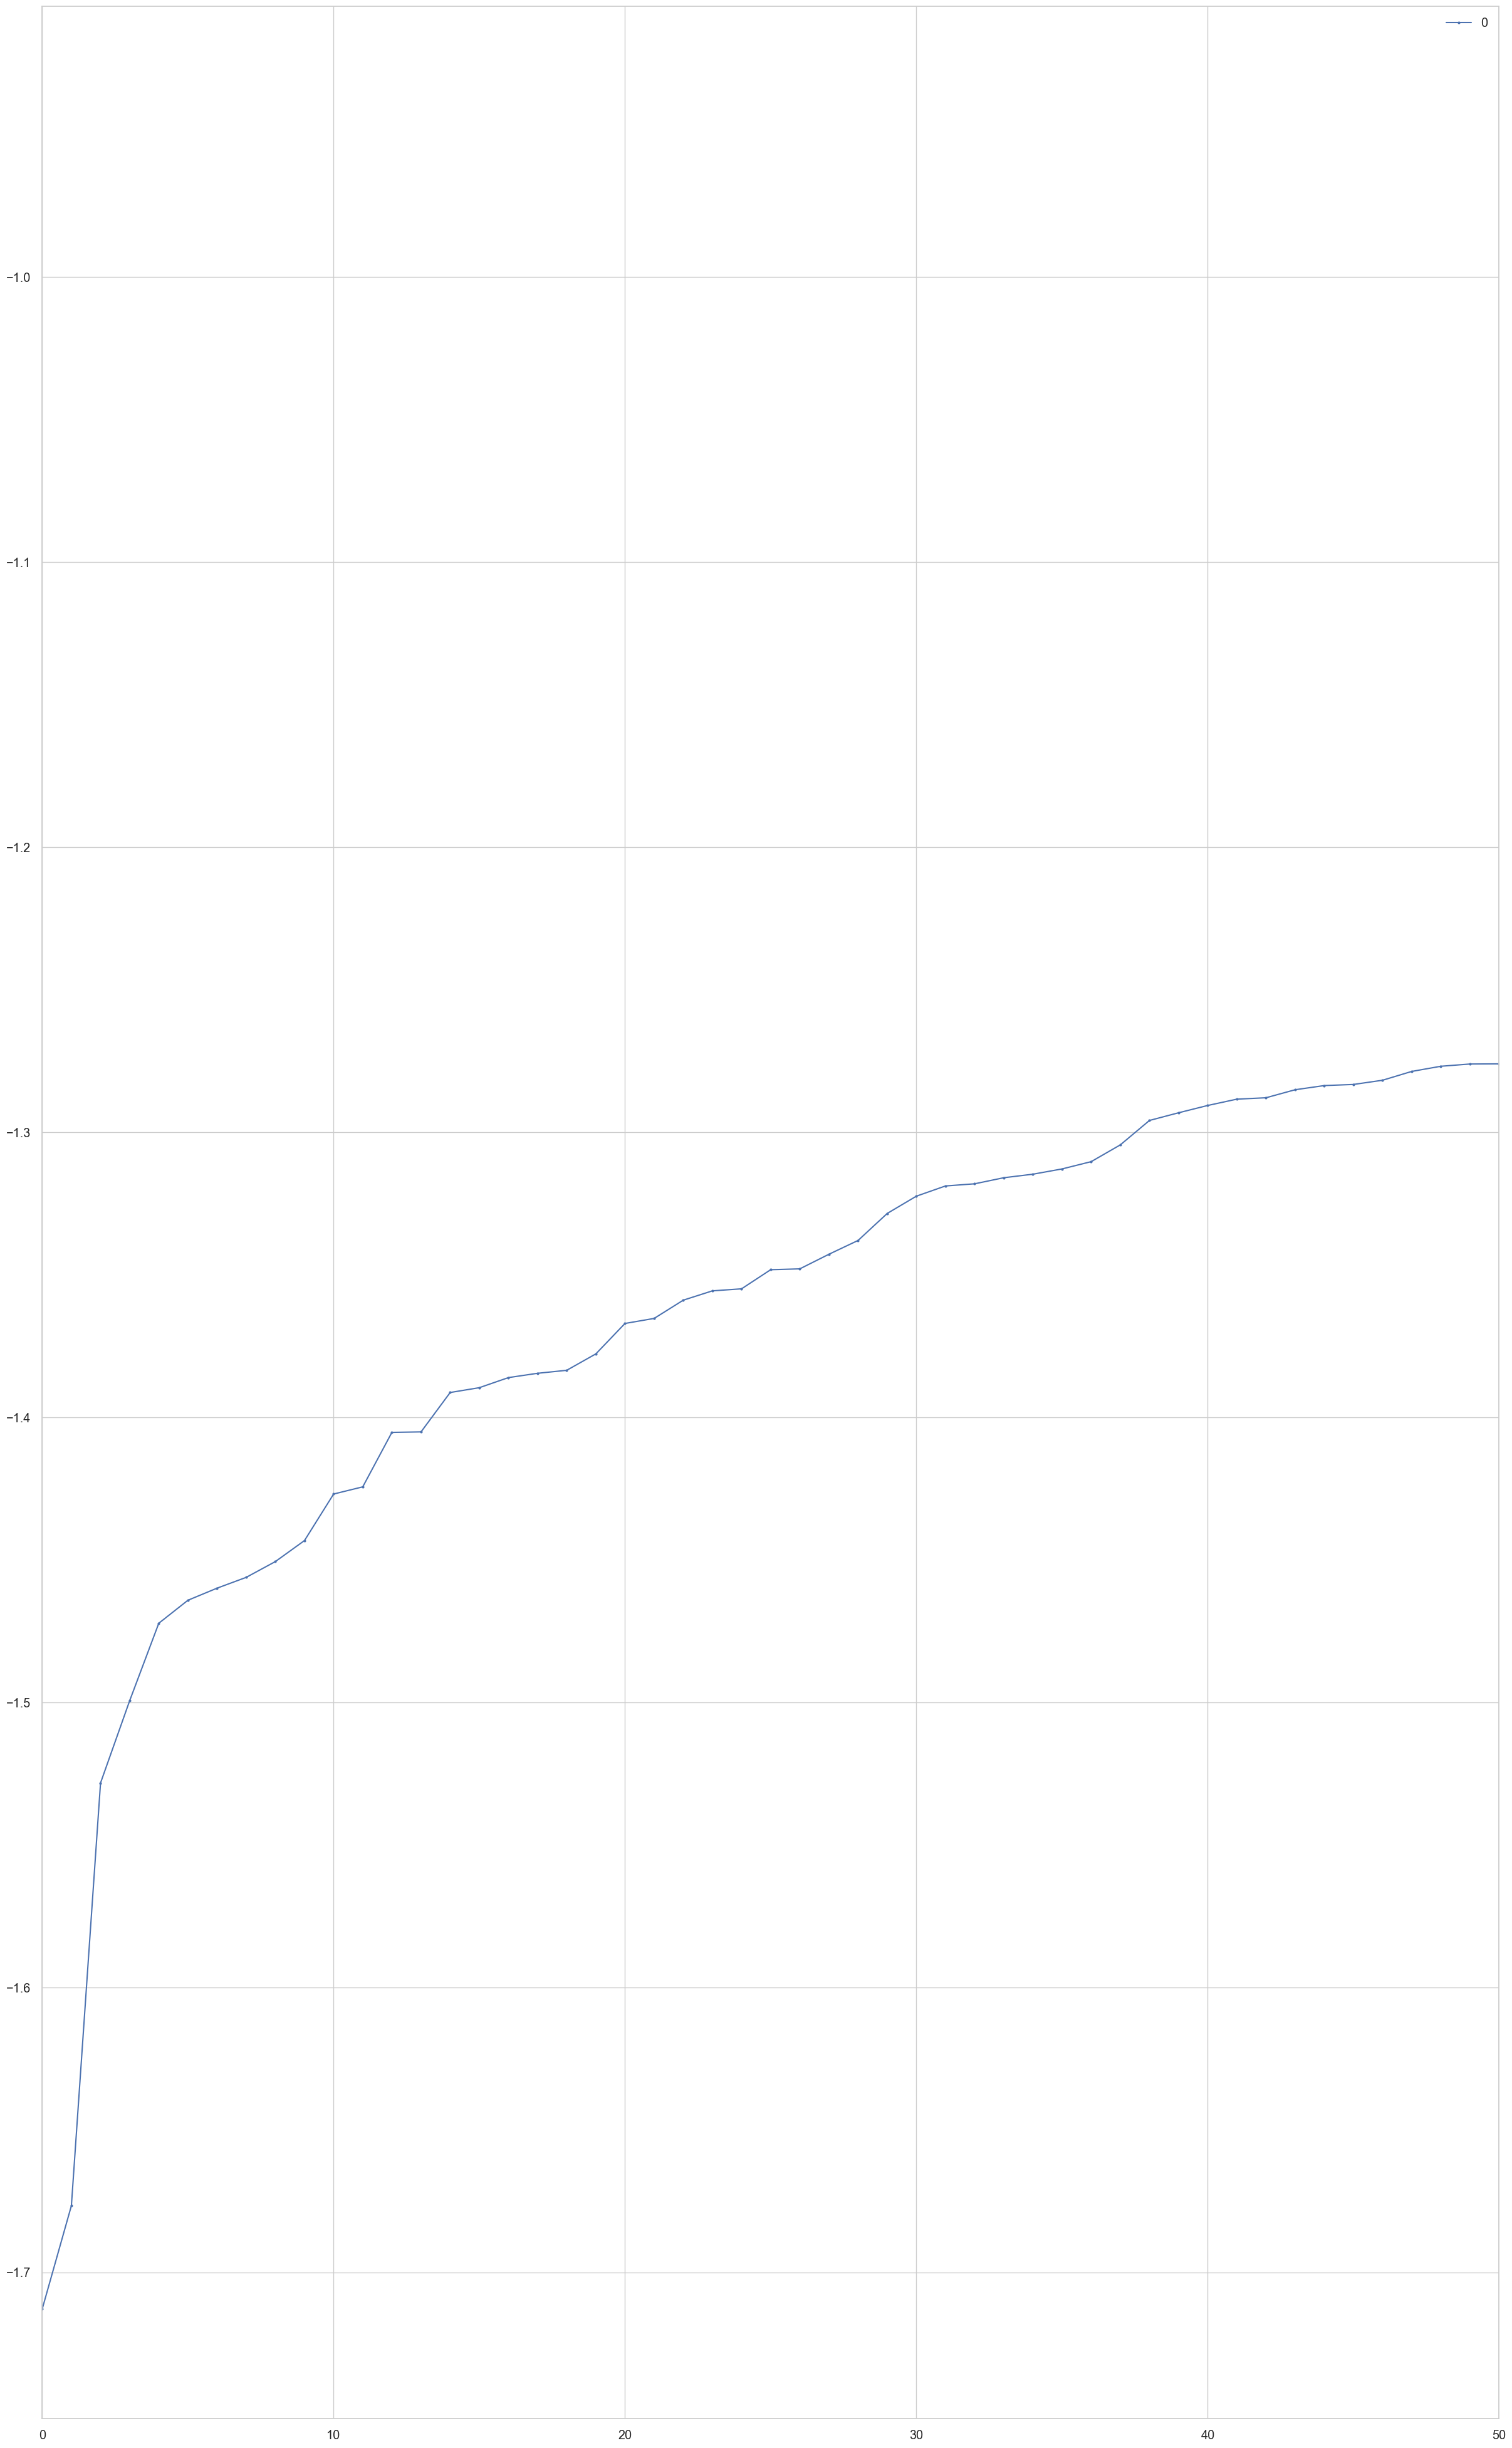

In [842]:
clf = LocalOutlierFactor(n_neighbors=20)
clf.fit_predict(df)
df_scores = clf.negative_outlier_factor_
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 50], style='.-')
plt.show()

In [843]:
th = np.sort(df_scores)[5]
df[df_scores < th].index
df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index, inplace=True)

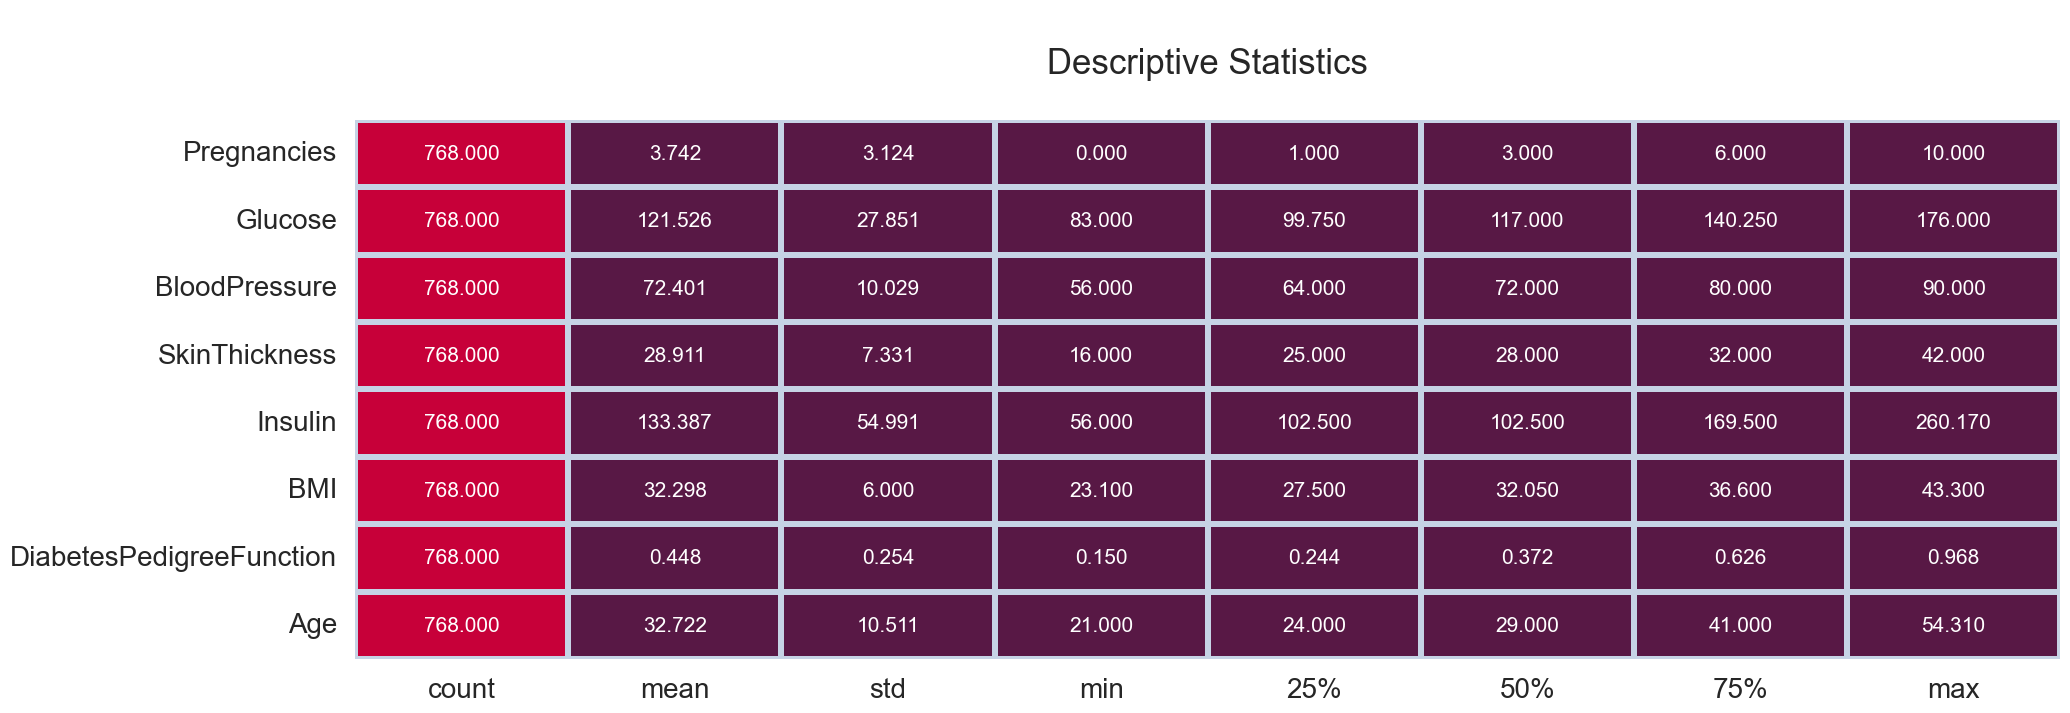

In [844]:
def descriptive_statistics(df):
    describe_ = df.describe().T
    describe_df = pd.DataFrame(index=df.columns,
                               columns=describe_.columns,
                               data=describe_)

    f, ax = plt.subplots(figsize=(22, 7))
    sns.heatmap(describe_df,
                annot=True,
                cmap=constraints,
                fmt='.3f',
                ax=ax,
                linecolor='#C6D3E5',
                linewidths=3,
                cbar=False,
                annot_kws={"size": 15})
    plt.xticks(size=20)
    plt.yticks(size=20,
               rotation=0)
    plt.title("\nDescriptive Statistics\n", size=25)
    plt.show()


num_desc = df[num_cols]
descriptive_statistics(num_desc)


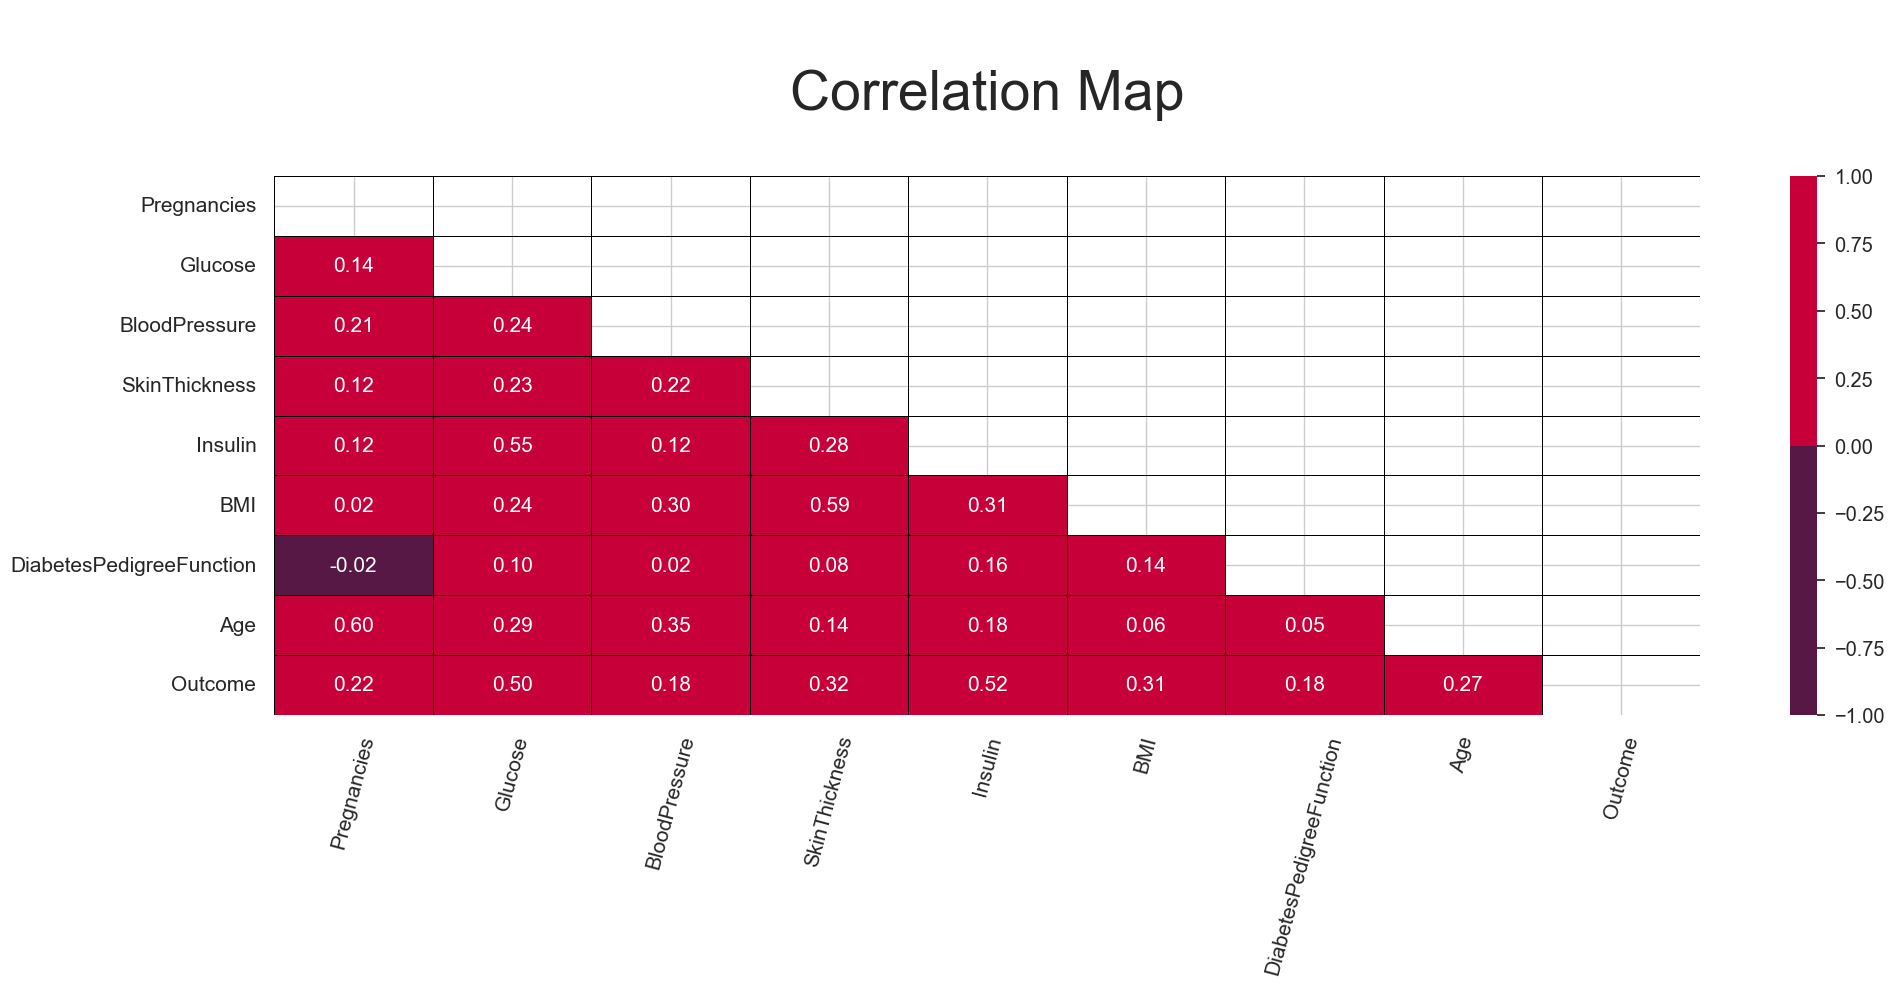

In [845]:
def corr_map(df, width=23, height=7):
    mtx = np.triu(df.corr())
    f, ax = plt.subplots(figsize=(width, height))
    sns.heatmap(df.corr(),
                annot=True,
                fmt=".2f",
                ax=ax,
                vmin=-1,
                vmax=1,
                cmap=constraints,
                mask=mtx,
                linewidth=0.4,
                linecolor="black",
                annot_kws={"size": 15})
    plt.yticks(rotation=0, size=15)
    plt.xticks(rotation=75, size=15)
    plt.title('\nCorrelation Map\n', size=40)
    plt.show()


corr_map(df)

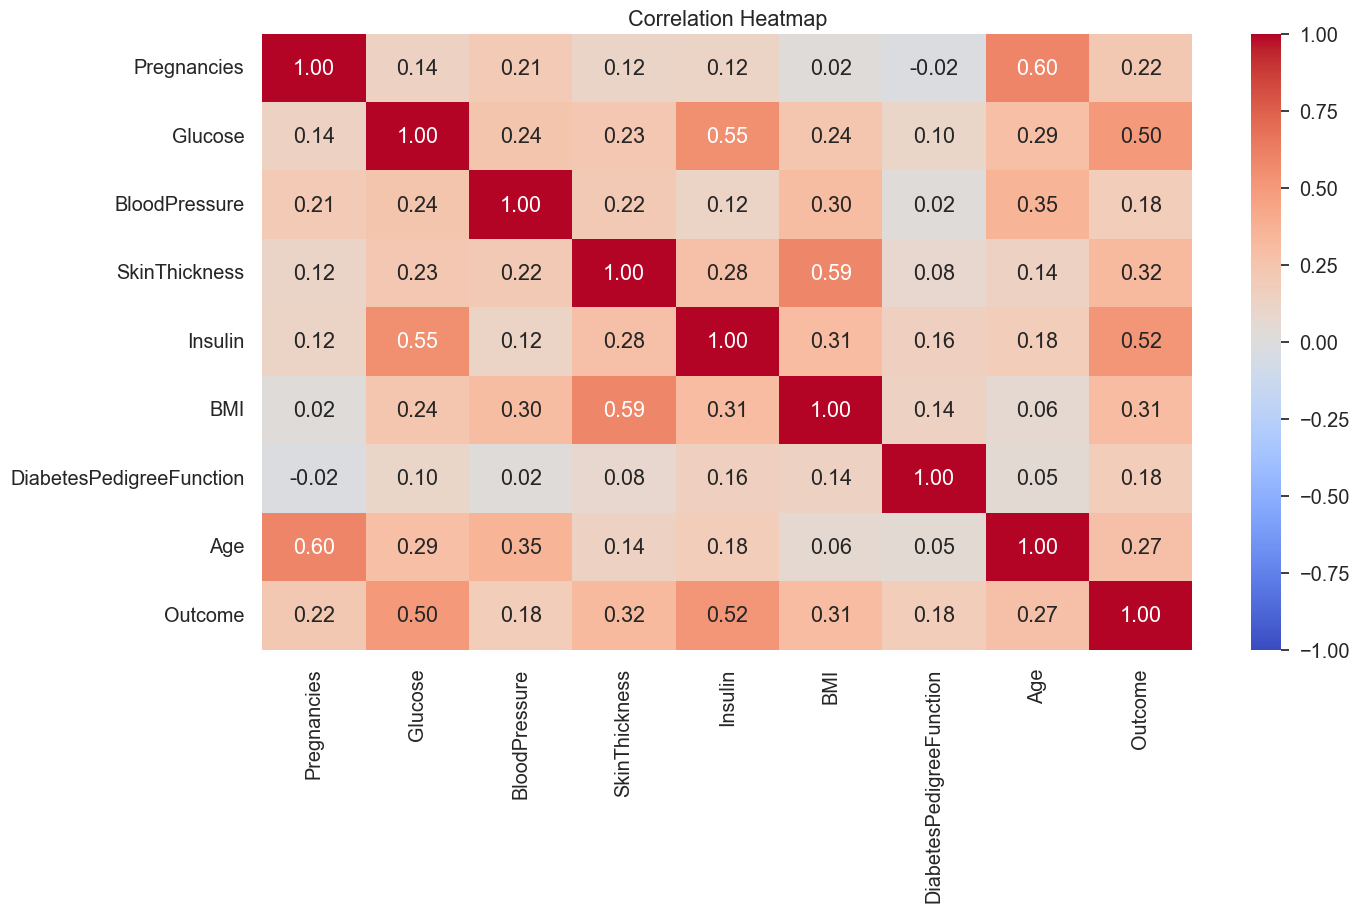

In [846]:
def plot_correlation_heatmap(dataframe):
    correlation_matrix = dataframe.corr()

    plt.figure(figsize=(15, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title("Correlation Heatmap")
    plt.show()


plot_correlation_heatmap(df)


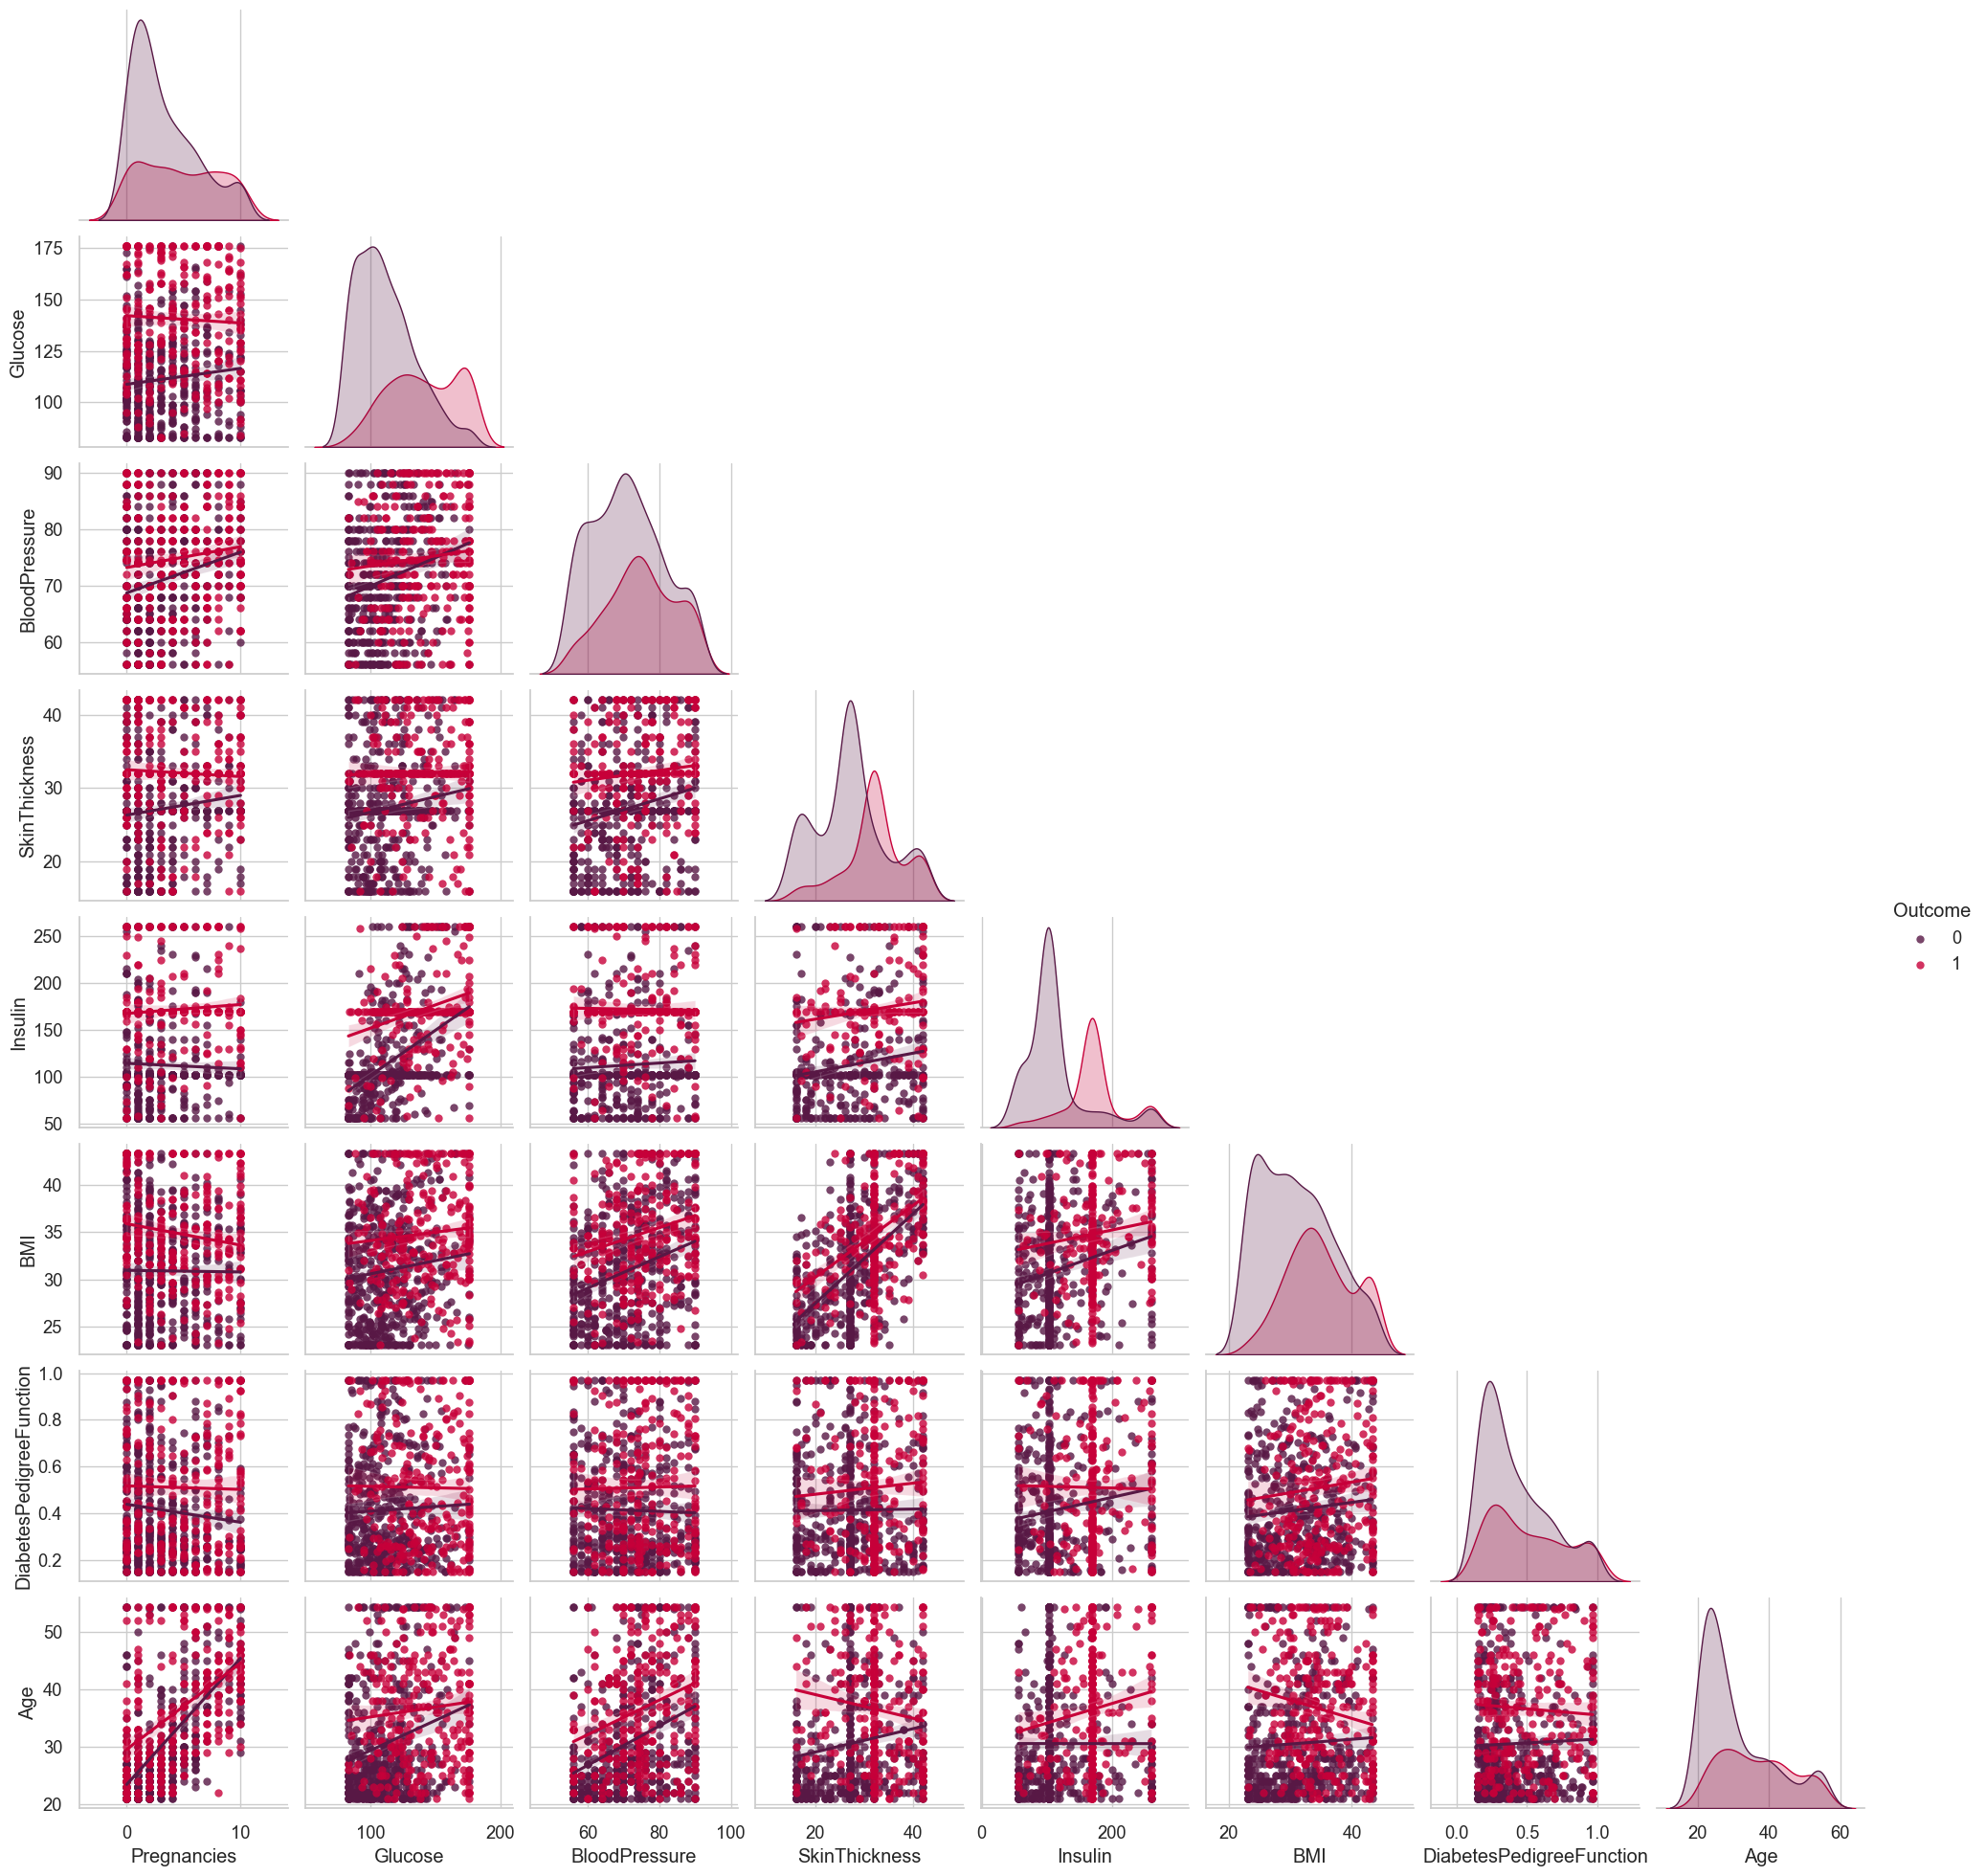

In [847]:
sns.set(font_scale=1.2,
        style="whitegrid",
        palette=constraints,
        font="sans-serif")
sns.pairplot(df,
             hue='Outcome',
             corner=True,
             kind='reg');

# Analysis of Numerical Features

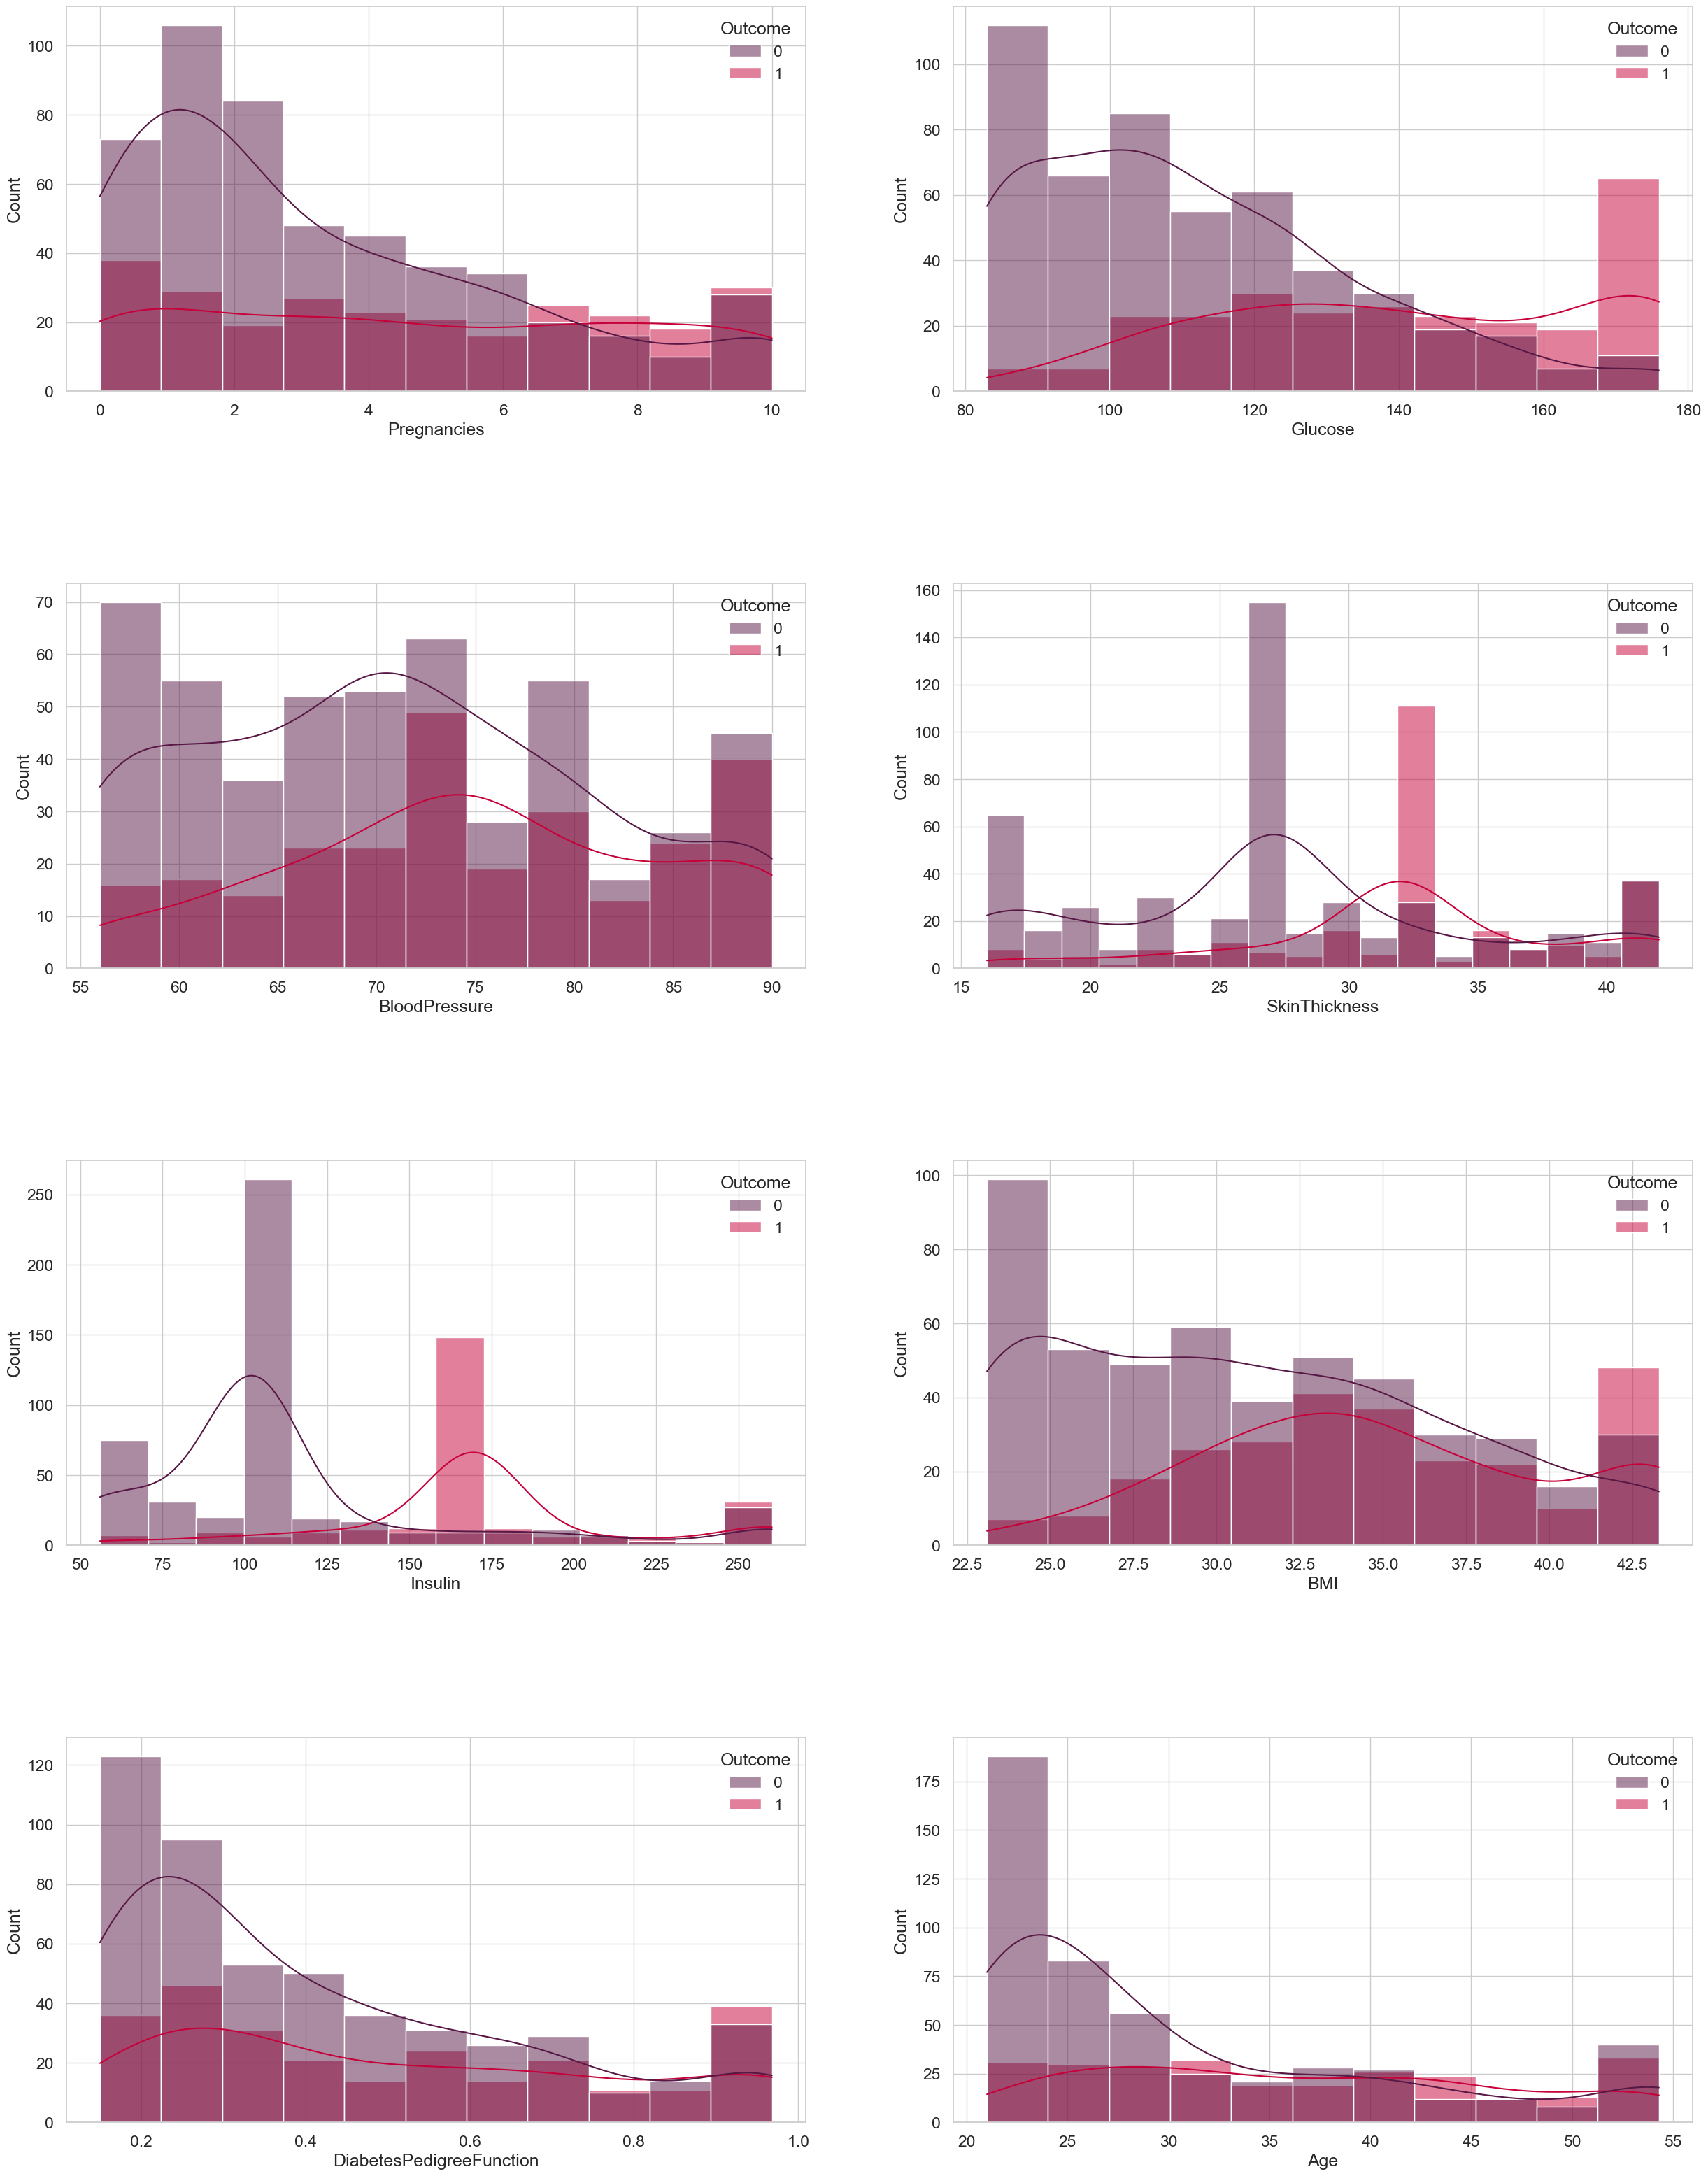

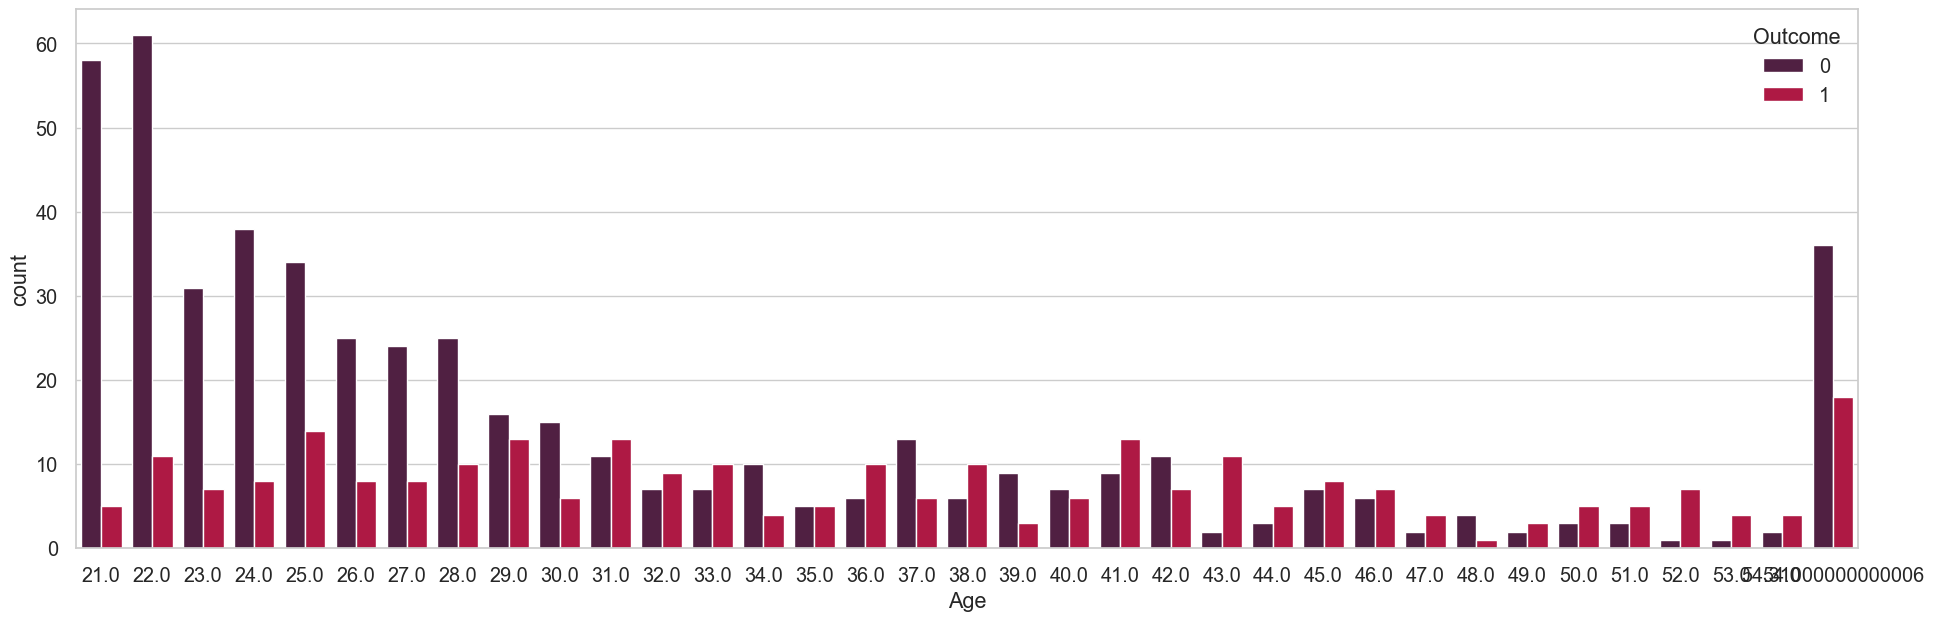

In [848]:
# def num_summary(df, numerical_col, plot=False):
#     quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
#     print(df[numerical_col].describe(quantiles))
# 
#     if plot:
#         plt.figure(figsize=(10, 5))
#         # df[numerical_col].hist(bins=20)
#         sns.histplot(df[numerical_col], kde=True)
#         plt.show()
# 
# 
# for col in num_cols:
#     num_summary(df, col, plot=True)


def num_features_hist(df, column_name, i, hue):
    rcParams['figure.figsize'] = 30, 50
    sns.set(font_scale=1.5)
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(5, 2, i)
    sns.histplot(data=df, x=column_name, hue=hue, kde=True, palette=constraints)


def num_summary(df, column_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Quantiles', 'Distribution'))

    fig.add_trace(go.Box(y=df[column_name],
                         name=str(column_name),
                         showlegend=False,
                         marker_color=constraints[1]),
                  row=1, col=1)

    fig.add_trace(go.Histogram(x=df[column_name],
                               xbins=dict(start=df[column_name].min(),
                                          end=df[column_name].max()),
                               showlegend=False,
                               name=str(column_name),
                               marker=dict(color=constraints[0],
                                           line=dict(color='#DBE6EC',
                                                     width=1))),
                  row=1, col=2)

    fig.update_layout(title={'text': column_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


i = 0
for column_name in num_cols:
    i = i + 1
    num_summary(df, column_name)
    num_features_hist(df, column_name, i, hue='Outcome')

plt.figure(figsize=(23, 7))
sns.set(font_scale=1.3)
sns.set_style("whitegrid")
plt.subplots_adjust(wspace=0.5)
sns.countplot(x=df['Age'], hue=df['Outcome'], palette=constraints);


# Analysis of Categorical Features

In [849]:
# def cat_summary(df, col_name, plot=False):
#     print(pd.DataFrame({col_name: df[col_name].value_counts(),
#                         "Ratio": 100 * df[col_name].value_counts() / len(df)}))
#     print("##########################################")
#     if plot:
#         sns.countplot(x=df[col_name], data=df)
#         plt.show()
# 
# 
# for col in cat_cols:
#     cat_summary(df, col, plot=True)


def categorical_variable_summary(df, column_name):
    fig = make_subplots(rows=1, cols=2,
                        subplot_titles=('Countplot', 'Percentages'),
                        specs=[[{"type": "xy"}, {'type': 'domain'}]])

    fig.add_trace(go.Bar(y=df[column_name].value_counts().values.tolist(),
                         x=[str(i) for i in df[column_name].value_counts().index],
                         text=df[column_name].value_counts().values.tolist(),
                         textfont=dict(size=15),
                         name=column_name,
                         textposition='auto',
                         showlegend=False,
                         marker=dict(color=cat_feat_constraints,
                                     line=dict(color='#DBE6EC',
                                               width=1))),
                  row=1, col=1)

    fig.add_trace(go.Pie(labels=df[column_name].value_counts().keys(),
                         values=df[column_name].value_counts().values,
                         textfont=dict(size=20),
                         textposition='auto',
                         showlegend=False,
                         name=column_name,
                         marker=dict(colors=cat_feat_constraints)),
                  row=1, col=2)

    fig.update_layout(title={'text': column_name,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')

    iplot(fig)


categorical_variable_summary(df, 'Outcome')

In [850]:
# Hedef değişken analizi 

# Kategorik değişkenlerin target değişkene göre analizi
def target_summary_with_cat(df, target, categorical_col):
    print(pd.DataFrame({"Target_Mean": df.groupby(categorical_col)[target].mean(),
                        "Count": df[categorical_col].value_counts(),
                        "Ratio": 100 * df[categorical_col].value_counts() / len(df)}))
    print("#" * 50)


for col in cat_cols:
    target_summary_with_cat(df, "Outcome", col)


         Target_Mean  Count    Ratio
Outcome                             
0            0.00000    500 65.10417
1            1.00000    268 34.89583
##################################################


In [851]:
# Numerik değişkenlerin target değişkenine göre analizi

def target_summary_with_num(df, target, numerical_col):
    print(df.groupby(target).agg({numerical_col: "mean"}))
    print("#" * 50)


for col in num_cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0            3.24000
1            4.67910
##################################################
          Glucose
Outcome          
0       111.34800
1       140.51493
##################################################
         BloodPressure
Outcome               
0             71.04600
1             74.92910
##################################################
         SkinThickness
Outcome               
0             27.21600
1             32.07463
##################################################
          Insulin
Outcome          
0       112.61284
1       172.14463
##################################################
             BMI
Outcome         
0       30.93240
1       34.84478
##################################################
         DiabetesPedigreeFunction
Outcome                          
0                         0.41418
1                         0.51055
##################################################
             Age
Outcome   

# Feature Engineering

In [852]:
def extract_features(dataframe):
    dataframe['BMI_CAT'] = pd.cut(x=dataframe['BMI'],
                                  bins=[0, 18.5, 24.9, 29.9,
                                        34.9, 39.9, np.inf],
                                  labels=["Underweight", "Healthy", "Overweight", "Obese Class I", "Obese Class II", "Obese Class III"])

    dataframe['Age_CAT'] = pd.cut(x=dataframe['Age'],
                                  bins=[0, 18, 30, 50, np.inf],
                                  labels=["Young", "Adult", "Middle-aged", "Senior"])

    dataframe['Glucose_CAT'] = pd.cut(x=dataframe['Glucose'],
                                      bins=[0, 100, 140, 199, np.inf],
                                      labels=["Low", "Normal", "Pre-Diabetes", "Diabetes"])

    dataframe['Insulin_CAT'] = pd.cut(x=dataframe['Insulin'],
                                      bins=[0, 100, 140, 199, np.inf],
                                      labels=["Low", "Normal", "Pre-High", "High"])

    dataframe['BloodPressure_CAT'] = pd.cut(x=dataframe['BloodPressure'],
                                            bins=[0, 80, 90, 120, np.inf],
                                            labels=["Low", "Normal", "Pre-High", "High"])

    dataframe['Pregnancy_Cat'] = pd.cut(x=dataframe['Pregnancies'],
                                        bins=[0, 1, 4, 10, np.inf],
                                        labels=["Childless", "One-Three",
                                                "Four-Nine", "Over-Ten"],
                                        right=False)


extract_features(df)

In [853]:
df["OBESE"] = np.where(df.BMI >= 30, 1, 0)
df["Is_Have_Child"] = np.where(df.Pregnancies > 0, 1, 0)

df["hypoglycaemia"] = np.where(df.Glucose < 70, 1, 0)
df["Glucose_Cat"] = np.where(df.Glucose < 140, 0, 1)  # 0 => No Risk , 1 => 1 At Risk

In [854]:
df['Glucose_BMI'] = df['Glucose'] * df['BMI']
df['Age_DiabetesPedigreeFunction'] = df['Age'] * df['DiabetesPedigreeFunction']
df['Pregnancies_Per_Age'] = df['Pregnancies'] / df['Age']
df['Glucose_Minus_Insulin'] = df['Glucose'] - df['Insulin']
df['GIR'] = df['Glucose'] / df['Insulin']
df['BMI_DiabetesPedigree'] = df['BMI'] * df['DiabetesPedigreeFunction']
df['Age_Insulin'] = df['Age'] * df['Insulin']
df['Glucose_BMI_Difference'] = df['Glucose'] - df['BMI']
df["glucose_per_bmi"] = df["Glucose"] / df["BMI"]
df["insulin_per_age"] = df["Insulin"] / df["Age"]


In [855]:
# def glucose_level(glucose):
#     if 16 <= glucose <= 140:
#         return "Normal"
#     elif 140 < glucose <= 200:
#         return "Prediabetes"
#     else:
#         return "Diabetes"


# df["Glucose_Level"] = df["Glucose"].apply(glucose_level)
############################################################

# def glucose_level(dataframe, col_name="Glucose"):
#     if 16 <= dataframe[col_name] <= 140:
#         return "Normal"
#     elif 140 < dataframe[col_name] <= 200:
#         return "Prediabetes"
#     else:
#         return "Diabetes"
# 
# 
# df["Glucose_Level"] = df.apply(glucose_level, axis=1)


In [856]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 768 	 Variables: 29
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_cols size: 11
cat_cols: ['Outcome', 'BMI_CAT', 'Age_CAT', 'Glucose_CAT', 'Insulin_CAT', 'BloodPressure_CAT', 'Pregnancy_Cat', 'OBESE', 'Is_Have_Child', 'hypoglycaemia', 'Glucose_Cat']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
num_cols size: 18
num_cols: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Glucose_BMI', 'Age_DiabetesPedigreeFunction', 'Pregnancies_Per_Age', 'Glucose_Minus_Insulin', 'GIR', 'BMI_DiabetesPedigree', 'Age_Insulin', 'Glucose_BMI_Difference', 'glucose_per_bmi', 'insulin_per_age']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
cat_but_car size: 0
cat_but_car: []
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

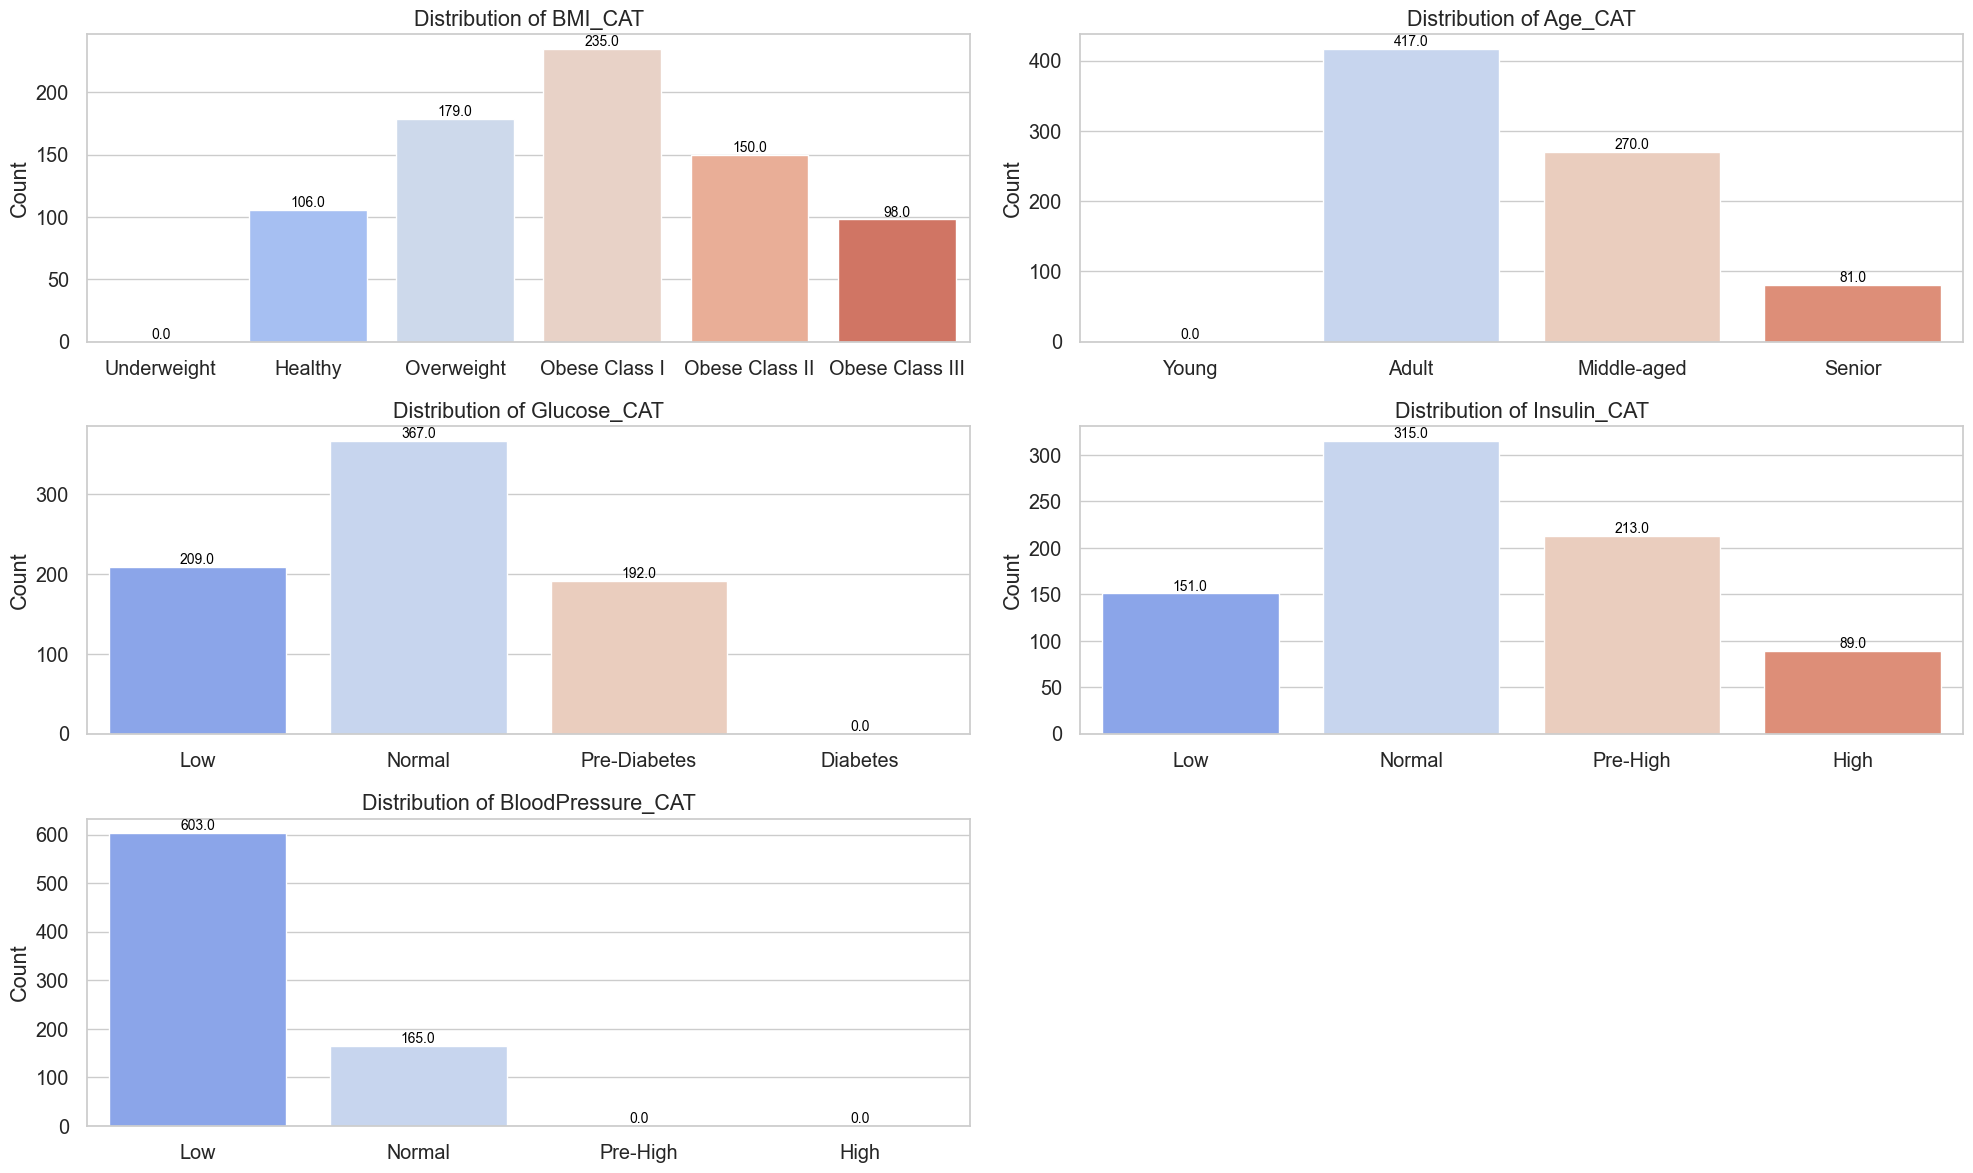

In [857]:
def visualize_new_features(dataframe):
    feature_columns = [col for col in df.columns if "_CAT" in col ]
    num_plots = len(feature_columns)
    num_cols = 2
    num_rows = (num_plots - 1) // num_cols + 1
    
    plt.figure(figsize=(num_plots*4, 12))
    
    for i, feature in enumerate(feature_columns, 1):
        plt.subplot(num_rows, num_cols, i)
        ax = sns.countplot(x=feature, data=dataframe, palette='coolwarm')
        plt.xlabel('')
        plt.ylabel('Count')
        plt.title(f'Distribution of {feature}')
        
        for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='bottom', fontsize=10, color='black')
    
    plt.tight_layout()
    plt.show()

visualize_new_features(df)

In [858]:
# Categorical Features Summary

def summary_cat_features(dataframe, column_name, label):
    data = go.Bar(x=dataframe.groupby(column_name).agg({label: 'mean'}).reset_index()[column_name],
                  y=dataframe.groupby(column_name).agg({label: 'mean'}).reset_index()[label],
                  text=round(dataframe.groupby(column_name).agg({label: 'mean'}).reset_index()[label], 3),
                  textposition='auto',
                  marker=dict(color=cat_feat_constraints, line_color='white', line_width=1.5))

    layt = go.Layout(title={'text': f'Average {label} by {column_name} Categories', 'y': 0.9, 'x': 0.2,
                            'xanchor': 'center', 'yanchor': 'top'},
                     xaxis=dict(title=column_name),
                     yaxis=dict(title=label),
                     template='plotly_white')

    fig = go.Figure(data=data, layout=layt)
    iplot(fig)


for i in [col for col in cat_cols if col != "Outcome"]:
    categorical_variable_summary(df, i)
    summary_cat_features(df, i, 'Outcome')

In [859]:
from IPython.display import display #I assume you are in a notebook

for i in [col for col in cat_cols if col != "Outcome"]:
    my = pd.crosstab(df.Outcome, df[i], margins=True).style.background_gradient(cmap='summer_r')
    display(my)

# Encoding Processing Control

In [860]:
class DataProcessorEncode:
    def __init__(self, cfg):
        self.cfg = cfg

    def encode_data(self, dataframe):
        if self.cfg.one_hot_encoder:
            # object_cols = dataframe.select_dtypes(include=['object', 'category']).columns
            object_cols = [col for col in dataframe.columns if 10 >= dataframe[col].nunique() > 2]

            if len(object_cols) > 0:
                dataframe = pd.get_dummies(dataframe, columns=object_cols, drop_first=True, dtype=int)
                print("One-hot encoding applied.")
            else:
                print("Warning: No object or category columns found. One-hot encoding was not applied.")


        if self.cfg.label_encoder:
            label_encoder = LabelEncoder()
            object_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ['object', 'category'] and dataframe[col].nunique() == 2]
            # object_cols = dataframe.select_dtypes(include=['object', 'category']).columns
            if len(object_cols) > 0:
                for col in object_cols:
                    dataframe[col] = label_encoder.fit_transform(dataframe[col])
                    print("Label encoding applied.")
            else:
                print("Warning: No object or category columns found. Label encoding was not applied.")
                
        if self.cfg.ordinal_encoder:
            ordinal_encoder = {}  # Boş bir sözlük oluşturuyoruz.
            object_cols = dataframe.select_dtypes(include=['object', 'category']).columns
            if len(object_cols) > 0:
                for col in object_cols:
                    unique_values = sorted(dataframe[col].unique())
                    ordinal_encoder[col] = {value: index for index, value in enumerate(unique_values)}
                    dataframe[col] = dataframe[col].map(ordinal_encoder[col])
                    print("Ordinal encoding applied.")
            else:
                print("Warning: No object or category columns found. Ordinal encoding was not applied.")


        return dataframe

data_processor_encode = DataProcessorEncode(CFG())
df = data_processor_encode.encode_data(df)
df.head()

One-hot encoding applied.
Label encoding applied.


Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin      BMI  DiabetesPedigreeFunction      Age  Outcome  BloodPressure_CAT  OBESE  Is_Have_Child  hypoglycaemia  Glucose_Cat  Glucose_BMI  Age_DiabetesPedigreeFunction  Pregnancies_Per_Age  Glucose_Minus_Insulin     GIR  BMI_DiabetesPedigree  Age_Insulin  Glucose_BMI_Difference  glucose_per_bmi  insulin_per_age  BMI_CAT_Healthy  BMI_CAT_Overweight  BMI_CAT_Obese Class I  BMI_CAT_Obese Class II  BMI_CAT_Obese Class III  Age_CAT_Adult  Age_CAT_Middle-aged  Age_CAT_Senior  Glucose_CAT_Normal  Glucose_CAT_Pre-Diabetes  \
474            4 114.00000       64.00000       27.00000 102.50000 28.90000                   0.14969 24.00000        0                  0      0              1              0            0   3294.60000                       3.59256              0.16667               11.50000 1.11220               4.32604   2460.00000                85.10000          3.94464          4.27083                0                   1                      0                       0                        0              1                    0               0                   1                         0   
332            1 176.00000       74.50000       32.00000 169.50000 43.30000                   0.28200 41.00000        1                  0      1              1              0            1   7620.80000                      11.56200              0.02439                6.50000 1.03835              12.21060   6949.50000               132.70000          4.06467          4.13415                0                   0                      0                       0                        1              0                    1               0                   0                         1   
546            5 176.00000       76.00000       27.00000 207.00000 43.30000                   0.96800 53.00000        1                  0      1              1              0            1   7620.80000                      51.30400              0.09434              -31.00000 0.85024              41.91440  10971.00000               132.70000          4.06467          3.90566                0                   0                      0                       0                        1              0                    0               1                   0                         1   
743            9 140.00000       90.00000       32.00000 169.50000 32.70000                   0.73400 45.00000        1                  1      1              1              0            1   4578.00000                      33.03000              0.20000              -29.50000 0.82596              24.00180   7627.50000               107.30000          4.28135          3.76667                0                   0                      1                       0                        0              0                    1               0                   1                         0   
507            1 130.00000       60.00000       23.00000 170.00000 28.60000                   0.69200 21.00000        0                  0      0              1              0            0   3718.00000                      14.53200              0.04762              -40.00000 0.76471              19.79120   3570.00000               101.40000          4.54545          8.09524                0                   1                      0                       0                        0              1                    0               0                   1                         0   

     Glucose_CAT_Diabetes  Insulin_CAT_Normal  Insulin_CAT_Pre-High  Insulin_CAT_High  Pregnancy_Cat_One-Three  Pregnancy_Cat_Four-Nine  Pregnancy_Cat_Over-Ten  
474                     0                   1                     0                 0                        0                        1                       0  
332                     0                   0                     1                 0                        1                        0                       

# Scaling Processing Control

In [861]:
def select_best_scaler(data, scaler_list, target_variable):
    results = {}

    for scaler in scaler_list:
        transformed_data = scaler.fit_transform(data)
        sample_model = KNeighborsClassifier()
        sample_model.fit(transformed_data, target_variable)
        accuracy = sample_model.score(transformed_data, target_variable)
        results[scaler] = accuracy

    best_scaler_name = max(results, key=results.get)

    return best_scaler_name

scaler_list = [StandardScaler(), MinMaxScaler(), RobustScaler()]
best_scaler = select_best_scaler(df, scaler_list, df['Outcome'])
print("Best scaler:", best_scaler)

# num_cols = df.select_dtypes(include=[int, float]).columns
# df[num_cols] = best_scaler.fit_transform(df[num_cols])
# print(f"{best_scaler} applied.")

if str(best_scaler) == "StandardScaler()":
    CFG.standard_scaler = True
elif str(best_scaler) == "MinMaxScaler()":
    CFG.min_max_scaler = True
elif str(best_scaler) == "RobustScaler()":
    CFG.robust_scaler = True    

Best scaler: MinMaxScaler()


In [862]:
class DataProcessorScaled:
    def __init__(self, cfg):
        self.cfg = cfg

    def scaled_data(self, dataframe):
        if self.cfg.min_max_scaler:
            num_cols = dataframe.select_dtypes(include=['int', 'float']).columns
            if len(num_cols) > 0:
                min_max_scaler = MinMaxScaler()
                dataframe[num_cols] = min_max_scaler.fit_transform(dataframe[num_cols])
                print("Min-Max scaling applied.")
            else:
                print("Warning: No numerical columns found. Min-Max scaling was not applied.")

        if self.cfg.standard_scaler:
            num_cols = dataframe.select_dtypes(include=['int', 'float']).columns
            if len(num_cols) > 0:
                standard_scaler = StandardScaler()
                dataframe[num_cols] = standard_scaler.fit_transform(dataframe[num_cols])
                print("Standard scaling applied.")
            else:
                print("Warning: No numerical columns found. Standard scaling was not applied.")

        if self.cfg.robust_scaler:
            num_cols = dataframe.select_dtypes(include=['int', 'float']).columns
            if len(num_cols) > 0:
                robust_scaler = RobustScaler()
                dataframe[num_cols] = robust_scaler.fit_transform(dataframe[num_cols])
                print("Robust scaling applied.")
            else:
                print("Warning: No numerical columns found. Robust scaling was not applied.")

        return dataframe
    
data_processor_scale = DataProcessorScaled(CFG())
df = data_processor_scale.scaled_data(df)
df.head()

Min-Max scaling applied.


Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin     BMI  DiabetesPedigreeFunction     Age  Outcome  BloodPressure_CAT   OBESE  Is_Have_Child  hypoglycaemia  Glucose_Cat  Glucose_BMI  Age_DiabetesPedigreeFunction  Pregnancies_Per_Age  Glucose_Minus_Insulin     GIR  BMI_DiabetesPedigree  Age_Insulin  Glucose_BMI_Difference  glucose_per_bmi  insulin_per_age  BMI_CAT_Healthy  BMI_CAT_Overweight  BMI_CAT_Obese Class I  BMI_CAT_Obese Class II  BMI_CAT_Obese Class III  Age_CAT_Adult  Age_CAT_Middle-aged  Age_CAT_Senior  Glucose_CAT_Normal  Glucose_CAT_Pre-Diabetes  \
474      0.40000  0.33333        0.23529        0.42308  0.22775 0.28713                   0.00000 0.09006  0.00000            0.00000 0.00000        1.00000        0.00000      0.00000      0.24148                       0.00909              0.45833                0.62063 0.27119               0.02258      0.09912                 0.40177          0.35833          0.28057          0.00000             1.00000                0.00000                 0.00000                  0.00000        1.00000              0.00000         0.00000             1.00000                   0.00000   
332      0.10000  1.00000        0.54412        0.61538  0.55591 1.00000                   0.16169 0.60042  1.00000            0.00000 1.00000        1.00000        0.00000      1.00000      1.00000                       0.17032              0.06707                0.60315 0.24469               0.22760      0.44570                 0.82301          0.37954          0.26846          0.00000             0.00000                0.00000                 0.00000                  1.00000        0.00000              1.00000         0.00000             0.00000                   1.00000   
546      0.50000  1.00000        0.58824        0.42308  0.73958 1.00000                   1.00000 0.96067  1.00000            0.00000 1.00000        1.00000        0.00000      1.00000      1.00000                       0.97435              0.25943                0.47203 0.17717               1.00000      0.75615                 0.82301          0.37954          0.24821          0.00000             0.00000                0.00000                 0.00000                  1.00000        0.00000              0.00000         1.00000             0.00000                   1.00000   
743      0.90000  0.61290        1.00000        0.61538  0.55591 0.47525                   0.71404 0.72050  1.00000            1.00000 1.00000        1.00000        0.00000      1.00000      0.46650                       0.60464              0.55000                0.47727 0.16846               0.53421      0.49804                 0.59823          0.41784          0.23589          0.00000             0.00000                1.00000                 0.00000                  0.00000        0.00000              1.00000         0.00000             1.00000                   0.00000   
507      0.10000  0.50538        0.11765        0.26923  0.55836 0.27228                   0.66272 0.00000  0.00000            0.00000 0.00000        1.00000        0.00000      0.00000      0.31572                       0.23040              0.13095                0.44056 0.14647               0.42472      0.18481                 0.54602          0.46451          0.61949          0.00000             1.00000                0.00000                 0.00000                  0.00000        1.00000              0.00000         0.00000             1.00000                   0.00000   

     Glucose_CAT_Diabetes  Insulin_CAT_Normal  Insulin_CAT_Pre-High  Insulin_CAT_High  Pregnancy_Cat_One-Three  Pregnancy_Cat_Four-Nine  Pregnancy_Cat_Over-Ten  
474               0.00000             1.00000               0.00000           0.00000                  0.00000                  1.00000                 0.00000  
332               0.00000             0.00000               1.00000           0.00000                  1.00000                  0.00000                 0.00000  
546           

# Train - Test Split

In [863]:
y = df['Outcome']
X = df.drop(['Outcome'], axis=1)
random_state = 135

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=random_state,
                                                    stratify=y,
                                                    test_size=0.2,
                                                    shuffle=True)

print(f"The shape of X_train: {colored(X_train.shape,'red')}")
print(f"The shape of X_test: {colored(X_test.shape,'red')}")
print(f"The shape of y_train: {colored(y_train.shape,'red')}")
print(f"The shape of y_test: {colored(y_test.shape,'red')}")

The shape of X_train: (614, 40)
The shape of X_test: (154, 40)
The shape of y_train: (614,)
The shape of y_test: (154,)


In [865]:
metric_res = []
models = []

models.append(("LGBMClassifier", LGBMClassifier(random_state = random_state)))
models.append(('XGBClassifier', XGBClassifier(random_state = random_state)))
models.append(('CatBoostClassifier', CatBoostClassifier(verbose=False, random_state = random_state)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state = random_state)))
models.append(('AdaBoostClassifier', AdaBoostClassifier(random_state = random_state)))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state = random_state)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state = random_state)))
models.append(('LogisticRegression', LogisticRegression(random_state = random_state)))
models.append(('MLPClassifier', MLPClassifier(random_state = random_state)))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))

In [866]:
def clc_ml(model):

    y_pred = model.fit(X_train, y_train).predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    score = model.score(X_test, y_test)

    # kfold = KFold(n_splits=10, shuffle=True)
    # cv_results = cross_val_score(model, X, y, cv=10, scoring="accuracy")
    
    kfold = KFold(n_splits=10, shuffle=True, random_state = random_state)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring="accuracy")
    cv_mean = cv_results.mean()

    mt_dataframe = pd.DataFrame({'Scores': [accuracy, score, cv_mean, f1, precision, recall, roc_auc],
                                 'Metrics': ['Accuracy',
                                             'Score',
                                             'Cross-Validation Mean',
                                             'F1-Score',
                                             'Precision',
                                             'Recall',
                                             'ROC-AUC',
                                             ]})
    model_results = pd.DataFrame({
        'Model': [name],
        'Accuracy': [accuracy],
        'Score': [score],
        'Cross-Validation Mean': [cv_mean],
        'F1-Score': [f1],
        'Precision': [precision],
        'Recall': [recall],
        'ROC-AUC': [roc_auc],
    })
    metric_res.append(model_results)

    fig = make_subplots(rows=1, cols=2)
    fig.add_trace(go.Bar(x=[round(i, 5) for i in mt_dataframe['Scores']],
                         y=mt_dataframe['Metrics'],
                         text=[round(i, 5) for i in mt_dataframe['Scores']],
                         orientation='h',
                         textposition='inside',
                         name='Scores',
                         marker=dict(color=metric_constraints,
                                     line_color='white',
                                     line_width=1.5)),
                  row=1, col=1)

    import inflect
    # Confusion matrix'in ısı haritasını çizdirme
    cm = confusion_matrix(y_test, y_pred)
    heatmap = go.Heatmap(
        z=cm,
        x=['0', '1'],
        y=['0', '1'],
        colorscale='Blues',
        texttemplate="%{z}"
    )
    fig.add_trace(heatmap, row=1, col=2)

    # İnflect motoru oluşturma
    p = inflect.engine()

    # Örnek veri çerçevesi
    df = px.data.medals_wide(indexed=True)

    # Veriyi izleme eğrisine çevirme ve çizdirme
    heatmap_trace = px.imshow(df, text_auto=True)
    for key in heatmap_trace:
        if 'heatmap' in key:
            fig.add_trace(heatmap_trace[key], row=1, col=2)

    fig.update_layout(title={'text': model.__class__.__name__,
                             'y': 0.9,
                             'x': 0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template='plotly_white')
    fig.update_xaxes(range=[0, 1], row=1, col=1)

    iplot(fig)


for name, model in models:
    clc_ml(model)

In [867]:
final_results = pd.concat(metric_res, ignore_index=True)
final_results.sort_values(by='Accuracy', ascending=False)

Model  Accuracy   Score  Cross-Validation Mean  F1-Score  Precision  Recall  ROC-AUC
4          AdaBoostClassifier   0.91558 0.91558                0.87628   0.88288    0.85965 0.90741  0.94102
0              LGBMClassifier   0.89610 0.89610                0.88806   0.85455    0.83929 0.87037  0.94704
1               XGBClassifier   0.88312 0.88312                0.88026   0.83929    0.81034 0.87037  0.94963
3  GradientBoostingClassifier   0.87662 0.87662                0.87638   0.82883    0.80702 0.85185  0.94537
5      RandomForestClassifier   0.87662 0.87662                0.88028   0.82569    0.81818 0.83333  0.93731
2          CatBoostClassifier   0.87013 0.87013                0.88028   0.81818    0.80357 0.83333  0.94704
7          LogisticRegression   0.85065 0.85065                0.86719   0.80342    0.74603 0.87037  0.93111
8               MLPClassifier   0.85065 0.85065                0.86594   0.79646    0.76271 0.83333  0.93019
9        KNeighborsClassifier   0.83117 0.83117                0.83992   0.77193    0.73333 0.81481  0.88602
6      DecisionTreeClassifier   0.81169 0.81169                0.82823   0.71845    0.75510 0.68519  0.78259

In [868]:
final_model = eval(final_results.sort_values(by='Accuracy', ascending=False).iloc[0, 0] + "(verbose=False)").fit(X_train, y_train) if final_results.sort_values(
    by='Accuracy', ascending=False).iloc[0, 0] == "CatBoostClassifier" else eval(final_results.sort_values(by='Accuracy', ascending=False).iloc[0, 0] + "()").fit(X_train, y_train)

# Model Tuning

In [894]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    learning_rate = trial.suggest_float("learning_rate", 0.001, 1.0, log=True)
    model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=random_state).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test, y_pred)

In [905]:
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(direction="maximize",
                                sampler=optuna.samplers.TPESampler(),)
study.optimize(objective, n_trials=100, n_jobs=-1)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2023-08-16 14:14:03,364] A new study created in memory with name: no-name-623826b6-7307-4ad7-bb0b-50d22ebc982a


A new study created in memory with name: no-name-623826b6-7307-4ad7-bb0b-50d22ebc982a
A new study created in memory with name: no-name-623826b6-7307-4ad7-bb0b-50d22ebc982a


[I 2023-08-16 14:14:04,961] Trial 14 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 61, 'learning_rate': 0.045515247050156145}. Best is trial 14 with value: 0.8831168831168831.


Trial 14 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 61, 'learning_rate': 0.045515247050156145}. Best is trial 14 with value: 0.8831168831168831.
Trial 14 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 61, 'learning_rate': 0.045515247050156145}. Best is trial 14 with value: 0.8831168831168831.


[I 2023-08-16 14:14:05,750] Trial 2 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 97, 'learning_rate': 0.22190127888698988}. Best is trial 2 with value: 0.8896103896103896.


Trial 2 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 97, 'learning_rate': 0.22190127888698988}. Best is trial 2 with value: 0.8896103896103896.
Trial 2 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 97, 'learning_rate': 0.22190127888698988}. Best is trial 2 with value: 0.8896103896103896.


[I 2023-08-16 14:14:07,612] Trial 11 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 172, 'learning_rate': 0.4117517235124959}. Best is trial 11 with value: 0.9025974025974026.


Trial 11 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 172, 'learning_rate': 0.4117517235124959}. Best is trial 11 with value: 0.9025974025974026.
Trial 11 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 172, 'learning_rate': 0.4117517235124959}. Best is trial 11 with value: 0.9025974025974026.


[I 2023-08-16 14:14:07,975] Trial 10 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 182, 'learning_rate': 0.04713664858850296}. Best is trial 11 with value: 0.9025974025974026.


Trial 10 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 182, 'learning_rate': 0.04713664858850296}. Best is trial 11 with value: 0.9025974025974026.
Trial 10 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 182, 'learning_rate': 0.04713664858850296}. Best is trial 11 with value: 0.9025974025974026.


[I 2023-08-16 14:14:08,767] Trial 7 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 220, 'learning_rate': 0.10395197305994935}. Best is trial 11 with value: 0.9025974025974026.


Trial 7 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 220, 'learning_rate': 0.10395197305994935}. Best is trial 11 with value: 0.9025974025974026.
Trial 7 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 220, 'learning_rate': 0.10395197305994935}. Best is trial 11 with value: 0.9025974025974026.


[I 2023-08-16 14:14:08,919] Trial 15 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 224, 'learning_rate': 0.7443458340866965}. Best is trial 11 with value: 0.9025974025974026.


Trial 15 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 224, 'learning_rate': 0.7443458340866965}. Best is trial 11 with value: 0.9025974025974026.
Trial 15 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 224, 'learning_rate': 0.7443458340866965}. Best is trial 11 with value: 0.9025974025974026.


[I 2023-08-16 14:14:09,069] Trial 9 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 228, 'learning_rate': 0.06756879590738647}. Best is trial 11 with value: 0.9025974025974026.


Trial 9 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 228, 'learning_rate': 0.06756879590738647}. Best is trial 11 with value: 0.9025974025974026.
Trial 9 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 228, 'learning_rate': 0.06756879590738647}. Best is trial 11 with value: 0.9025974025974026.


[I 2023-08-16 14:14:09,261] Trial 3 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 236, 'learning_rate': 0.13815048750121356}. Best is trial 11 with value: 0.9025974025974026.


Trial 3 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 236, 'learning_rate': 0.13815048750121356}. Best is trial 11 with value: 0.9025974025974026.
Trial 3 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 236, 'learning_rate': 0.13815048750121356}. Best is trial 11 with value: 0.9025974025974026.


[I 2023-08-16 14:14:09,802] Trial 0 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 258, 'learning_rate': 0.1102337595565866}. Best is trial 11 with value: 0.9025974025974026.


Trial 0 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 258, 'learning_rate': 0.1102337595565866}. Best is trial 11 with value: 0.9025974025974026.
Trial 0 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 258, 'learning_rate': 0.1102337595565866}. Best is trial 11 with value: 0.9025974025974026.


[I 2023-08-16 14:14:09,929] Trial 8 finished with value: 0.8051948051948052 and parameters: {'n_estimators': 272, 'learning_rate': 0.002344445986451381}. Best is trial 11 with value: 0.9025974025974026.


Trial 8 finished with value: 0.8051948051948052 and parameters: {'n_estimators': 272, 'learning_rate': 0.002344445986451381}. Best is trial 11 with value: 0.9025974025974026.
Trial 8 finished with value: 0.8051948051948052 and parameters: {'n_estimators': 272, 'learning_rate': 0.002344445986451381}. Best is trial 11 with value: 0.9025974025974026.


[I 2023-08-16 14:14:10,745] Trial 17 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 202, 'learning_rate': 0.012107362977046766}. Best is trial 11 with value: 0.9025974025974026.


Trial 17 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 202, 'learning_rate': 0.012107362977046766}. Best is trial 11 with value: 0.9025974025974026.
Trial 17 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 202, 'learning_rate': 0.012107362977046766}. Best is trial 11 with value: 0.9025974025974026.


[I 2023-08-16 14:14:11,076] Trial 13 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 315, 'learning_rate': 0.6902497271955185}. Best is trial 13 with value: 0.9090909090909091.


Trial 13 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 315, 'learning_rate': 0.6902497271955185}. Best is trial 13 with value: 0.9090909090909091.
Trial 13 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 315, 'learning_rate': 0.6902497271955185}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:11,690] Trial 6 finished with value: 0.8636363636363636 and parameters: {'n_estimators': 345, 'learning_rate': 0.004924300733555024}. Best is trial 13 with value: 0.9090909090909091.


Trial 6 finished with value: 0.8636363636363636 and parameters: {'n_estimators': 345, 'learning_rate': 0.004924300733555024}. Best is trial 13 with value: 0.9090909090909091.
Trial 6 finished with value: 0.8636363636363636 and parameters: {'n_estimators': 345, 'learning_rate': 0.004924300733555024}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:11,753] Trial 5 finished with value: 0.8051948051948052 and parameters: {'n_estimators': 344, 'learning_rate': 0.0021407973256541684}. Best is trial 13 with value: 0.9090909090909091.


Trial 5 finished with value: 0.8051948051948052 and parameters: {'n_estimators': 344, 'learning_rate': 0.0021407973256541684}. Best is trial 13 with value: 0.9090909090909091.
Trial 5 finished with value: 0.8051948051948052 and parameters: {'n_estimators': 344, 'learning_rate': 0.0021407973256541684}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:12,443] Trial 1 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 369, 'learning_rate': 0.15988860309841524}. Best is trial 13 with value: 0.9090909090909091.


Trial 1 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 369, 'learning_rate': 0.15988860309841524}. Best is trial 13 with value: 0.9090909090909091.
Trial 1 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 369, 'learning_rate': 0.15988860309841524}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:12,522] Trial 4 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 371, 'learning_rate': 0.0056858959028275435}. Best is trial 13 with value: 0.9090909090909091.


Trial 4 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 371, 'learning_rate': 0.0056858959028275435}. Best is trial 13 with value: 0.9090909090909091.
Trial 4 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 371, 'learning_rate': 0.0056858959028275435}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:12,765] Trial 12 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 377, 'learning_rate': 0.06512691400751558}. Best is trial 13 with value: 0.9090909090909091.


Trial 12 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 377, 'learning_rate': 0.06512691400751558}. Best is trial 13 with value: 0.9090909090909091.
Trial 12 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 377, 'learning_rate': 0.06512691400751558}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:12,952] Trial 16 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 321, 'learning_rate': 0.11232749781427893}. Best is trial 13 with value: 0.9090909090909091.


Trial 16 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 321, 'learning_rate': 0.11232749781427893}. Best is trial 13 with value: 0.9090909090909091.
Trial 16 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 321, 'learning_rate': 0.11232749781427893}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:13,497] Trial 19 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 227, 'learning_rate': 0.03868951568795886}. Best is trial 13 with value: 0.9090909090909091.


Trial 19 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 227, 'learning_rate': 0.03868951568795886}. Best is trial 13 with value: 0.9090909090909091.
Trial 19 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 227, 'learning_rate': 0.03868951568795886}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:13,830] Trial 22 finished with value: 0.8376623376623377 and parameters: {'n_estimators': 190, 'learning_rate': 0.007287730183246369}. Best is trial 13 with value: 0.9090909090909091.


Trial 22 finished with value: 0.8376623376623377 and parameters: {'n_estimators': 190, 'learning_rate': 0.007287730183246369}. Best is trial 13 with value: 0.9090909090909091.
Trial 22 finished with value: 0.8376623376623377 and parameters: {'n_estimators': 190, 'learning_rate': 0.007287730183246369}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:14,300] Trial 20 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 226, 'learning_rate': 0.009982131055109207}. Best is trial 13 with value: 0.9090909090909091.


Trial 20 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 226, 'learning_rate': 0.009982131055109207}. Best is trial 13 with value: 0.9090909090909091.
Trial 20 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 226, 'learning_rate': 0.009982131055109207}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:14,867] Trial 18 finished with value: 0.8636363636363636 and parameters: {'n_estimators': 303, 'learning_rate': 0.01742417147871748}. Best is trial 13 with value: 0.9090909090909091.


Trial 18 finished with value: 0.8636363636363636 and parameters: {'n_estimators': 303, 'learning_rate': 0.01742417147871748}. Best is trial 13 with value: 0.9090909090909091.
Trial 18 finished with value: 0.8636363636363636 and parameters: {'n_estimators': 303, 'learning_rate': 0.01742417147871748}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:15,962] Trial 23 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 287, 'learning_rate': 0.5494928052006405}. Best is trial 13 with value: 0.9090909090909091.


Trial 23 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 287, 'learning_rate': 0.5494928052006405}. Best is trial 13 with value: 0.9090909090909091.
Trial 23 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 287, 'learning_rate': 0.5494928052006405}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:17,668] Trial 21 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 362, 'learning_rate': 0.027958187735969517}. Best is trial 13 with value: 0.9090909090909091.


Trial 21 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 362, 'learning_rate': 0.027958187735969517}. Best is trial 13 with value: 0.9090909090909091.
Trial 21 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 362, 'learning_rate': 0.027958187735969517}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:19,714] Trial 25 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 419, 'learning_rate': 0.8920272033358094}. Best is trial 13 with value: 0.9090909090909091.


Trial 25 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 419, 'learning_rate': 0.8920272033358094}. Best is trial 13 with value: 0.9090909090909091.
Trial 25 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 419, 'learning_rate': 0.8920272033358094}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:20,430] Trial 24 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 447, 'learning_rate': 0.03738669015543092}. Best is trial 13 with value: 0.9090909090909091.


Trial 24 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 447, 'learning_rate': 0.03738669015543092}. Best is trial 13 with value: 0.9090909090909091.
Trial 24 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 447, 'learning_rate': 0.03738669015543092}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:20,729] Trial 27 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 408, 'learning_rate': 0.9740682650053125}. Best is trial 13 with value: 0.9090909090909091.


Trial 27 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 408, 'learning_rate': 0.9740682650053125}. Best is trial 13 with value: 0.9090909090909091.
Trial 27 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 408, 'learning_rate': 0.9740682650053125}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:22,239] Trial 26 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 486, 'learning_rate': 0.9615042625943176}. Best is trial 13 with value: 0.9090909090909091.


Trial 26 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 486, 'learning_rate': 0.9615042625943176}. Best is trial 13 with value: 0.9090909090909091.
Trial 26 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 486, 'learning_rate': 0.9615042625943176}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:22,406] Trial 29 finished with value: 0.8636363636363636 and parameters: {'n_estimators': 458, 'learning_rate': 0.967411113570378}. Best is trial 13 with value: 0.9090909090909091.


Trial 29 finished with value: 0.8636363636363636 and parameters: {'n_estimators': 458, 'learning_rate': 0.967411113570378}. Best is trial 13 with value: 0.9090909090909091.
Trial 29 finished with value: 0.8636363636363636 and parameters: {'n_estimators': 458, 'learning_rate': 0.967411113570378}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:22,615] Trial 28 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 469, 'learning_rate': 0.7242935576342575}. Best is trial 13 with value: 0.9090909090909091.


Trial 28 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 469, 'learning_rate': 0.7242935576342575}. Best is trial 13 with value: 0.9090909090909091.
Trial 28 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 469, 'learning_rate': 0.7242935576342575}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:23,120] Trial 32 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 445, 'learning_rate': 0.9396454405945884}. Best is trial 13 with value: 0.9090909090909091.


Trial 32 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 445, 'learning_rate': 0.9396454405945884}. Best is trial 13 with value: 0.9090909090909091.
Trial 32 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 445, 'learning_rate': 0.9396454405945884}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:23,793] Trial 30 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 473, 'learning_rate': 0.6628680632581605}. Best is trial 13 with value: 0.9090909090909091.


Trial 30 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 473, 'learning_rate': 0.6628680632581605}. Best is trial 13 with value: 0.9090909090909091.
Trial 30 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 473, 'learning_rate': 0.6628680632581605}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:23,972] Trial 41 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 147, 'learning_rate': 0.4227292506231564}. Best is trial 13 with value: 0.9090909090909091.


Trial 41 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 147, 'learning_rate': 0.4227292506231564}. Best is trial 13 with value: 0.9090909090909091.
Trial 41 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 147, 'learning_rate': 0.4227292506231564}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:24,184] Trial 31 finished with value: 0.8636363636363636 and parameters: {'n_estimators': 493, 'learning_rate': 0.9998264825881583}. Best is trial 13 with value: 0.9090909090909091.


Trial 31 finished with value: 0.8636363636363636 and parameters: {'n_estimators': 493, 'learning_rate': 0.9998264825881583}. Best is trial 13 with value: 0.9090909090909091.
Trial 31 finished with value: 0.8636363636363636 and parameters: {'n_estimators': 493, 'learning_rate': 0.9998264825881583}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:24,309] Trial 34 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 463, 'learning_rate': 0.7548360962189011}. Best is trial 13 with value: 0.9090909090909091.


Trial 34 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 463, 'learning_rate': 0.7548360962189011}. Best is trial 13 with value: 0.9090909090909091.
Trial 34 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 463, 'learning_rate': 0.7548360962189011}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:24,530] Trial 35 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 454, 'learning_rate': 0.3817455804819615}. Best is trial 13 with value: 0.9090909090909091.


Trial 35 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 454, 'learning_rate': 0.3817455804819615}. Best is trial 13 with value: 0.9090909090909091.
Trial 35 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 454, 'learning_rate': 0.3817455804819615}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:24,625] Trial 33 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 484, 'learning_rate': 0.8766851660410669}. Best is trial 13 with value: 0.9090909090909091.


Trial 33 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 484, 'learning_rate': 0.8766851660410669}. Best is trial 13 with value: 0.9090909090909091.
Trial 33 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 484, 'learning_rate': 0.8766851660410669}. Best is trial 13 with value: 0.9090909090909091.


[I 2023-08-16 14:14:24,722] Trial 42 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 155, 'learning_rate': 0.34165000102741583}. Best is trial 42 with value: 0.9155844155844156.


Trial 42 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 155, 'learning_rate': 0.34165000102741583}. Best is trial 42 with value: 0.9155844155844156.
Trial 42 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 155, 'learning_rate': 0.34165000102741583}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:25,286] Trial 37 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 437, 'learning_rate': 0.6324580086852112}. Best is trial 42 with value: 0.9155844155844156.


Trial 37 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 437, 'learning_rate': 0.6324580086852112}. Best is trial 42 with value: 0.9155844155844156.
Trial 37 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 437, 'learning_rate': 0.6324580086852112}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:26,032] Trial 36 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 490, 'learning_rate': 0.538384551256484}. Best is trial 42 with value: 0.9155844155844156.


Trial 36 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 490, 'learning_rate': 0.538384551256484}. Best is trial 42 with value: 0.9155844155844156.
Trial 36 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 490, 'learning_rate': 0.538384551256484}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:26,078] Trial 44 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 145, 'learning_rate': 0.3742478990229739}. Best is trial 42 with value: 0.9155844155844156.


Trial 44 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 145, 'learning_rate': 0.3742478990229739}. Best is trial 42 with value: 0.9155844155844156.
Trial 44 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 145, 'learning_rate': 0.3742478990229739}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:26,329] Trial 43 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 161, 'learning_rate': 0.3896158819388448}. Best is trial 42 with value: 0.9155844155844156.


Trial 43 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 161, 'learning_rate': 0.3896158819388448}. Best is trial 42 with value: 0.9155844155844156.
Trial 43 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 161, 'learning_rate': 0.3896158819388448}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:26,769] Trial 45 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 164, 'learning_rate': 0.2928434305373275}. Best is trial 42 with value: 0.9155844155844156.


Trial 45 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 164, 'learning_rate': 0.2928434305373275}. Best is trial 42 with value: 0.9155844155844156.
Trial 45 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 164, 'learning_rate': 0.2928434305373275}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:27,298] Trial 38 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 471, 'learning_rate': 0.35094556408614247}. Best is trial 42 with value: 0.9155844155844156.


Trial 38 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 471, 'learning_rate': 0.35094556408614247}. Best is trial 42 with value: 0.9155844155844156.
Trial 38 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 471, 'learning_rate': 0.35094556408614247}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:27,699] Trial 47 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 148, 'learning_rate': 0.381544196163098}. Best is trial 42 with value: 0.9155844155844156.


Trial 47 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 148, 'learning_rate': 0.381544196163098}. Best is trial 42 with value: 0.9155844155844156.
Trial 47 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 148, 'learning_rate': 0.381544196163098}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:28,031] Trial 53 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 134, 'learning_rate': 0.2335340410350812}. Best is trial 42 with value: 0.9155844155844156.


Trial 53 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 134, 'learning_rate': 0.2335340410350812}. Best is trial 42 with value: 0.9155844155844156.
Trial 53 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 134, 'learning_rate': 0.2335340410350812}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:28,552] Trial 39 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 449, 'learning_rate': 0.3649284862953366}. Best is trial 42 with value: 0.9155844155844156.


Trial 39 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 449, 'learning_rate': 0.3649284862953366}. Best is trial 42 with value: 0.9155844155844156.
Trial 39 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 449, 'learning_rate': 0.3649284862953366}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:28,610] Trial 54 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 131, 'learning_rate': 0.1878444176340228}. Best is trial 42 with value: 0.9155844155844156.


Trial 54 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 131, 'learning_rate': 0.1878444176340228}. Best is trial 42 with value: 0.9155844155844156.
Trial 54 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 131, 'learning_rate': 0.1878444176340228}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:29,442] Trial 55 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 134, 'learning_rate': 0.20448511295985336}. Best is trial 42 with value: 0.9155844155844156.


Trial 55 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 134, 'learning_rate': 0.20448511295985336}. Best is trial 42 with value: 0.9155844155844156.
Trial 55 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 134, 'learning_rate': 0.20448511295985336}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:29,644] Trial 57 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 124, 'learning_rate': 0.2475594379987082}. Best is trial 42 with value: 0.9155844155844156.


Trial 57 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 124, 'learning_rate': 0.2475594379987082}. Best is trial 42 with value: 0.9155844155844156.
Trial 57 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 124, 'learning_rate': 0.2475594379987082}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:29,703] Trial 56 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 136, 'learning_rate': 0.2451155547386762}. Best is trial 42 with value: 0.9155844155844156.


Trial 56 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 136, 'learning_rate': 0.2451155547386762}. Best is trial 42 with value: 0.9155844155844156.
Trial 56 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 136, 'learning_rate': 0.2451155547386762}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:30,268] Trial 58 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 134, 'learning_rate': 0.19873654309395902}. Best is trial 42 with value: 0.9155844155844156.


Trial 58 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 134, 'learning_rate': 0.19873654309395902}. Best is trial 42 with value: 0.9155844155844156.
Trial 58 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 134, 'learning_rate': 0.19873654309395902}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:30,587] Trial 59 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 123, 'learning_rate': 0.20524221067187134}. Best is trial 42 with value: 0.9155844155844156.


Trial 59 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 123, 'learning_rate': 0.20524221067187134}. Best is trial 42 with value: 0.9155844155844156.
Trial 59 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 123, 'learning_rate': 0.20524221067187134}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:30,760] Trial 60 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 110, 'learning_rate': 0.20310918348002924}. Best is trial 42 with value: 0.9155844155844156.


Trial 60 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 110, 'learning_rate': 0.20310918348002924}. Best is trial 42 with value: 0.9155844155844156.
Trial 60 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 110, 'learning_rate': 0.20310918348002924}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:30,849] Trial 46 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 301, 'learning_rate': 0.4026757735402908}. Best is trial 42 with value: 0.9155844155844156.


Trial 46 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 301, 'learning_rate': 0.4026757735402908}. Best is trial 42 with value: 0.9155844155844156.
Trial 46 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 301, 'learning_rate': 0.4026757735402908}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:30,962] Trial 61 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 108, 'learning_rate': 0.17378790589311555}. Best is trial 42 with value: 0.9155844155844156.


Trial 61 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 108, 'learning_rate': 0.17378790589311555}. Best is trial 42 with value: 0.9155844155844156.
Trial 61 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 108, 'learning_rate': 0.17378790589311555}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:31,235] Trial 63 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 98, 'learning_rate': 0.17809965257900803}. Best is trial 42 with value: 0.9155844155844156.


Trial 63 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 98, 'learning_rate': 0.17809965257900803}. Best is trial 42 with value: 0.9155844155844156.
Trial 63 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 98, 'learning_rate': 0.17809965257900803}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:31,416] Trial 62 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 109, 'learning_rate': 0.18550781419596948}. Best is trial 42 with value: 0.9155844155844156.


Trial 62 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 109, 'learning_rate': 0.18550781419596948}. Best is trial 42 with value: 0.9155844155844156.
Trial 62 finished with value: 0.8831168831168831 and parameters: {'n_estimators': 109, 'learning_rate': 0.18550781419596948}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:31,646] Trial 65 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 73, 'learning_rate': 0.1404505443856482}. Best is trial 42 with value: 0.9155844155844156.


Trial 65 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 73, 'learning_rate': 0.1404505443856482}. Best is trial 42 with value: 0.9155844155844156.
Trial 65 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 73, 'learning_rate': 0.1404505443856482}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:31,717] Trial 40 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 480, 'learning_rate': 0.4481807996721894}. Best is trial 42 with value: 0.9155844155844156.


Trial 40 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 480, 'learning_rate': 0.4481807996721894}. Best is trial 42 with value: 0.9155844155844156.
Trial 40 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 480, 'learning_rate': 0.4481807996721894}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:31,816] Trial 48 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 302, 'learning_rate': 0.3167022610902778}. Best is trial 42 with value: 0.9155844155844156.
[I 2023-08-16 14:14:31,817] Trial 64 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 86, 'learning_rate': 0.13543582989638023}. Best is trial 42 with value: 0.9155844155844156.


Trial 48 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 302, 'learning_rate': 0.3167022610902778}. Best is trial 42 with value: 0.9155844155844156.
Trial 48 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 302, 'learning_rate': 0.3167022610902778}. Best is trial 42 with value: 0.9155844155844156.
Trial 64 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 86, 'learning_rate': 0.13543582989638023}. Best is trial 42 with value: 0.9155844155844156.
Trial 64 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 86, 'learning_rate': 0.13543582989638023}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:31,906] Trial 49 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 295, 'learning_rate': 0.30036505321327434}. Best is trial 42 with value: 0.9155844155844156.


Trial 49 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 295, 'learning_rate': 0.30036505321327434}. Best is trial 42 with value: 0.9155844155844156.
Trial 49 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 295, 'learning_rate': 0.30036505321327434}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:32,195] Trial 50 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 302, 'learning_rate': 0.24065632693288233}. Best is trial 42 with value: 0.9155844155844156.


Trial 50 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 302, 'learning_rate': 0.24065632693288233}. Best is trial 42 with value: 0.9155844155844156.
Trial 50 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 302, 'learning_rate': 0.24065632693288233}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:32,362] Trial 52 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 300, 'learning_rate': 0.23095961619837244}. Best is trial 42 with value: 0.9155844155844156.


Trial 52 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 300, 'learning_rate': 0.23095961619837244}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:32,367] Trial 66 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 97, 'learning_rate': 0.48616282828380325}. Best is trial 42 with value: 0.9155844155844156.


Trial 52 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 300, 'learning_rate': 0.23095961619837244}. Best is trial 42 with value: 0.9155844155844156.
Trial 66 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 97, 'learning_rate': 0.48616282828380325}. Best is trial 42 with value: 0.9155844155844156.
Trial 66 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 97, 'learning_rate': 0.48616282828380325}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:32,636] Trial 51 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 311, 'learning_rate': 0.22181555020542207}. Best is trial 42 with value: 0.9155844155844156.


Trial 51 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 311, 'learning_rate': 0.22181555020542207}. Best is trial 42 with value: 0.9155844155844156.
Trial 51 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 311, 'learning_rate': 0.22181555020542207}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:32,972] Trial 67 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 96, 'learning_rate': 0.4871111609202783}. Best is trial 42 with value: 0.9155844155844156.


Trial 67 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 96, 'learning_rate': 0.4871111609202783}. Best is trial 42 with value: 0.9155844155844156.
Trial 67 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 96, 'learning_rate': 0.4871111609202783}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:33,088] Trial 71 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 71, 'learning_rate': 0.1411909703916534}. Best is trial 42 with value: 0.9155844155844156.


Trial 71 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 71, 'learning_rate': 0.1411909703916534}. Best is trial 42 with value: 0.9155844155844156.
Trial 71 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 71, 'learning_rate': 0.1411909703916534}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:33,257] Trial 68 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 89, 'learning_rate': 0.15517247478349044}. Best is trial 42 with value: 0.9155844155844156.


Trial 68 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 89, 'learning_rate': 0.15517247478349044}. Best is trial 42 with value: 0.9155844155844156.
Trial 68 finished with value: 0.8766233766233766 and parameters: {'n_estimators': 89, 'learning_rate': 0.15517247478349044}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:39,148] Trial 70 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 244, 'learning_rate': 0.4846876650882814}. Best is trial 42 with value: 0.9155844155844156.


Trial 70 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 244, 'learning_rate': 0.4846876650882814}. Best is trial 42 with value: 0.9155844155844156.
Trial 70 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 244, 'learning_rate': 0.4846876650882814}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:40,163] Trial 72 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 255, 'learning_rate': 0.5038444451224788}. Best is trial 42 with value: 0.9155844155844156.


Trial 72 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 255, 'learning_rate': 0.5038444451224788}. Best is trial 42 with value: 0.9155844155844156.
Trial 72 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 255, 'learning_rate': 0.5038444451224788}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:40,624] Trial 74 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 248, 'learning_rate': 0.5074670768247781}. Best is trial 42 with value: 0.9155844155844156.


Trial 74 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 248, 'learning_rate': 0.5074670768247781}. Best is trial 42 with value: 0.9155844155844156.
Trial 74 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 248, 'learning_rate': 0.5074670768247781}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:40,735] Trial 75 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 253, 'learning_rate': 0.30396418661435726}. Best is trial 42 with value: 0.9155844155844156.


Trial 75 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 253, 'learning_rate': 0.30396418661435726}. Best is trial 42 with value: 0.9155844155844156.
Trial 75 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 253, 'learning_rate': 0.30396418661435726}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:40,780] Trial 77 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 244, 'learning_rate': 0.5001092146858855}. Best is trial 42 with value: 0.9155844155844156.


Trial 77 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 244, 'learning_rate': 0.5001092146858855}. Best is trial 42 with value: 0.9155844155844156.
Trial 77 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 244, 'learning_rate': 0.5001092146858855}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:41,132] Trial 78 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 246, 'learning_rate': 0.5048796191976164}. Best is trial 42 with value: 0.9155844155844156.


Trial 78 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 246, 'learning_rate': 0.5048796191976164}. Best is trial 42 with value: 0.9155844155844156.
Trial 78 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 246, 'learning_rate': 0.5048796191976164}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:41,213] Trial 73 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 257, 'learning_rate': 0.48053818950713933}. Best is trial 42 with value: 0.9155844155844156.


Trial 73 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 257, 'learning_rate': 0.48053818950713933}. Best is trial 42 with value: 0.9155844155844156.
Trial 73 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 257, 'learning_rate': 0.48053818950713933}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:41,364] Trial 79 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 243, 'learning_rate': 0.5383525944382135}. Best is trial 42 with value: 0.9155844155844156.


Trial 79 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 243, 'learning_rate': 0.5383525944382135}. Best is trial 42 with value: 0.9155844155844156.
Trial 79 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 243, 'learning_rate': 0.5383525944382135}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:41,577] Trial 76 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 259, 'learning_rate': 0.5108307495680903}. Best is trial 42 with value: 0.9155844155844156.


Trial 76 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 259, 'learning_rate': 0.5108307495680903}. Best is trial 42 with value: 0.9155844155844156.
Trial 76 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 259, 'learning_rate': 0.5108307495680903}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:42,073] Trial 81 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 251, 'learning_rate': 0.5473365010016003}. Best is trial 42 with value: 0.9155844155844156.


Trial 81 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 251, 'learning_rate': 0.5473365010016003}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:42,079] Trial 80 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 258, 'learning_rate': 0.5064071005012486}. Best is trial 42 with value: 0.9155844155844156.


Trial 81 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 251, 'learning_rate': 0.5473365010016003}. Best is trial 42 with value: 0.9155844155844156.
Trial 80 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 258, 'learning_rate': 0.5064071005012486}. Best is trial 42 with value: 0.9155844155844156.
Trial 80 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 258, 'learning_rate': 0.5064071005012486}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:42,471] Trial 82 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 259, 'learning_rate': 0.5769352407655085}. Best is trial 42 with value: 0.9155844155844156.


Trial 82 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 259, 'learning_rate': 0.5769352407655085}. Best is trial 42 with value: 0.9155844155844156.
Trial 82 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 259, 'learning_rate': 0.5769352407655085}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:42,732] Trial 69 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 322, 'learning_rate': 0.49038012160742445}. Best is trial 42 with value: 0.9155844155844156.


Trial 69 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 322, 'learning_rate': 0.49038012160742445}. Best is trial 42 with value: 0.9155844155844156.
Trial 69 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 322, 'learning_rate': 0.49038012160742445}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:42,996] Trial 83 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 264, 'learning_rate': 0.31084738180419874}. Best is trial 42 with value: 0.9155844155844156.


Trial 83 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 264, 'learning_rate': 0.31084738180419874}. Best is trial 42 with value: 0.9155844155844156.
Trial 83 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 264, 'learning_rate': 0.31084738180419874}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:43,445] Trial 85 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 252, 'learning_rate': 0.302086536716642}. Best is trial 42 with value: 0.9155844155844156.


Trial 85 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 252, 'learning_rate': 0.302086536716642}. Best is trial 42 with value: 0.9155844155844156.
Trial 85 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 252, 'learning_rate': 0.302086536716642}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:43,467] Trial 84 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 261, 'learning_rate': 0.29796306173484843}. Best is trial 42 with value: 0.9155844155844156.


Trial 84 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 261, 'learning_rate': 0.29796306173484843}. Best is trial 42 with value: 0.9155844155844156.
Trial 84 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 261, 'learning_rate': 0.29796306173484843}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:48,266] Trial 88 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 210, 'learning_rate': 0.30311250851374555}. Best is trial 42 with value: 0.9155844155844156.


Trial 88 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 210, 'learning_rate': 0.30311250851374555}. Best is trial 42 with value: 0.9155844155844156.
Trial 88 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 210, 'learning_rate': 0.30311250851374555}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:48,566] Trial 92 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 207, 'learning_rate': 0.6082034329830345}. Best is trial 42 with value: 0.9155844155844156.


Trial 92 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 207, 'learning_rate': 0.6082034329830345}. Best is trial 42 with value: 0.9155844155844156.
Trial 92 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 207, 'learning_rate': 0.6082034329830345}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:48,642] Trial 93 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 205, 'learning_rate': 0.6178059586086317}. Best is trial 42 with value: 0.9155844155844156.


Trial 93 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 205, 'learning_rate': 0.6178059586086317}. Best is trial 42 with value: 0.9155844155844156.
Trial 93 finished with value: 0.9155844155844156 and parameters: {'n_estimators': 205, 'learning_rate': 0.6178059586086317}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:49,214] Trial 95 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 204, 'learning_rate': 0.6424069463953792}. Best is trial 42 with value: 0.9155844155844156.


Trial 95 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 204, 'learning_rate': 0.6424069463953792}. Best is trial 42 with value: 0.9155844155844156.
Trial 95 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 204, 'learning_rate': 0.6424069463953792}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:50,812] Trial 86 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 327, 'learning_rate': 0.30223075192227317}. Best is trial 42 with value: 0.9155844155844156.


Trial 86 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 327, 'learning_rate': 0.30223075192227317}. Best is trial 42 with value: 0.9155844155844156.
Trial 86 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 327, 'learning_rate': 0.30223075192227317}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:51,377] Trial 87 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 336, 'learning_rate': 0.6093029542851689}. Best is trial 42 with value: 0.9155844155844156.


Trial 87 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 336, 'learning_rate': 0.6093029542851689}. Best is trial 42 with value: 0.9155844155844156.
Trial 87 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 336, 'learning_rate': 0.6093029542851689}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:51,763] Trial 90 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 336, 'learning_rate': 0.2975401031498455}. Best is trial 42 with value: 0.9155844155844156.


Trial 90 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 336, 'learning_rate': 0.2975401031498455}. Best is trial 42 with value: 0.9155844155844156.
Trial 90 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 336, 'learning_rate': 0.2975401031498455}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:51,865] Trial 91 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 338, 'learning_rate': 0.6458403139049113}. Best is trial 42 with value: 0.9155844155844156.


Trial 91 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 338, 'learning_rate': 0.6458403139049113}. Best is trial 42 with value: 0.9155844155844156.
Trial 91 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 338, 'learning_rate': 0.6458403139049113}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:52,019] Trial 94 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 331, 'learning_rate': 0.6507928404509556}. Best is trial 42 with value: 0.9155844155844156.


Trial 94 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 331, 'learning_rate': 0.6507928404509556}. Best is trial 42 with value: 0.9155844155844156.
Trial 94 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 331, 'learning_rate': 0.6507928404509556}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:52,148] Trial 89 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 346, 'learning_rate': 0.6114464865338066}. Best is trial 42 with value: 0.9155844155844156.


Trial 89 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 346, 'learning_rate': 0.6114464865338066}. Best is trial 42 with value: 0.9155844155844156.
Trial 89 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 346, 'learning_rate': 0.6114464865338066}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:52,434] Trial 96 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 338, 'learning_rate': 0.716062746767457}. Best is trial 42 with value: 0.9155844155844156.


Trial 96 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 338, 'learning_rate': 0.716062746767457}. Best is trial 42 with value: 0.9155844155844156.
Trial 96 finished with value: 0.8896103896103896 and parameters: {'n_estimators': 338, 'learning_rate': 0.716062746767457}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:52,549] Trial 97 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 348, 'learning_rate': 0.6911911543144977}. Best is trial 42 with value: 0.9155844155844156.


Trial 97 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 348, 'learning_rate': 0.6911911543144977}. Best is trial 42 with value: 0.9155844155844156.
Trial 97 finished with value: 0.8961038961038961 and parameters: {'n_estimators': 348, 'learning_rate': 0.6911911543144977}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:52,561] Trial 99 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 331, 'learning_rate': 0.7732580360671653}. Best is trial 42 with value: 0.9155844155844156.


Trial 99 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 331, 'learning_rate': 0.7732580360671653}. Best is trial 42 with value: 0.9155844155844156.
Trial 99 finished with value: 0.9090909090909091 and parameters: {'n_estimators': 331, 'learning_rate': 0.7732580360671653}. Best is trial 42 with value: 0.9155844155844156.


[I 2023-08-16 14:14:52,602] Trial 98 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 339, 'learning_rate': 0.7085238030963477}. Best is trial 42 with value: 0.9155844155844156.


Trial 98 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 339, 'learning_rate': 0.7085238030963477}. Best is trial 42 with value: 0.9155844155844156.
Trial 98 finished with value: 0.9025974025974026 and parameters: {'n_estimators': 339, 'learning_rate': 0.7085238030963477}. Best is trial 42 with value: 0.9155844155844156.
Number of finished trials:  100
Best trial:
  Value:  0.9155844155844156
  Params: 
    n_estimators: 155
    learning_rate: 0.34165000102741583


In [906]:
final_model = AdaBoostClassifier(n_estimators=trial.params["n_estimators"], learning_rate=trial.params["learning_rate"], random_state=random_state).fit(X_train, y_train)

y_pred = final_model.predict(X_test)

Accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
score = final_model.score(X_test, y_test)
kfold = KFold(n_splits=10, shuffle=True, random_state=random_state)
cv_results = cross_val_score(final_model, X, y, cv=kfold, scoring="accuracy")
cv_mean = cv_results.mean()


results = pd.DataFrame({
        'Accuracy': [Accuracy],
        'Score': [score],
        'Cross-Validation Mean': [cv_mean],
        'F1-Score': [f1],
        'Precision': [precision],
        'Recall': [recall],
        'ROC-AUC': [roc_auc],
    })
results

Accuracy   Score  Cross-Validation Mean  F1-Score  Precision  Recall  ROC-AUC
0   0.91558 0.91558                0.87637   0.88496    0.84746 0.92593  0.95963

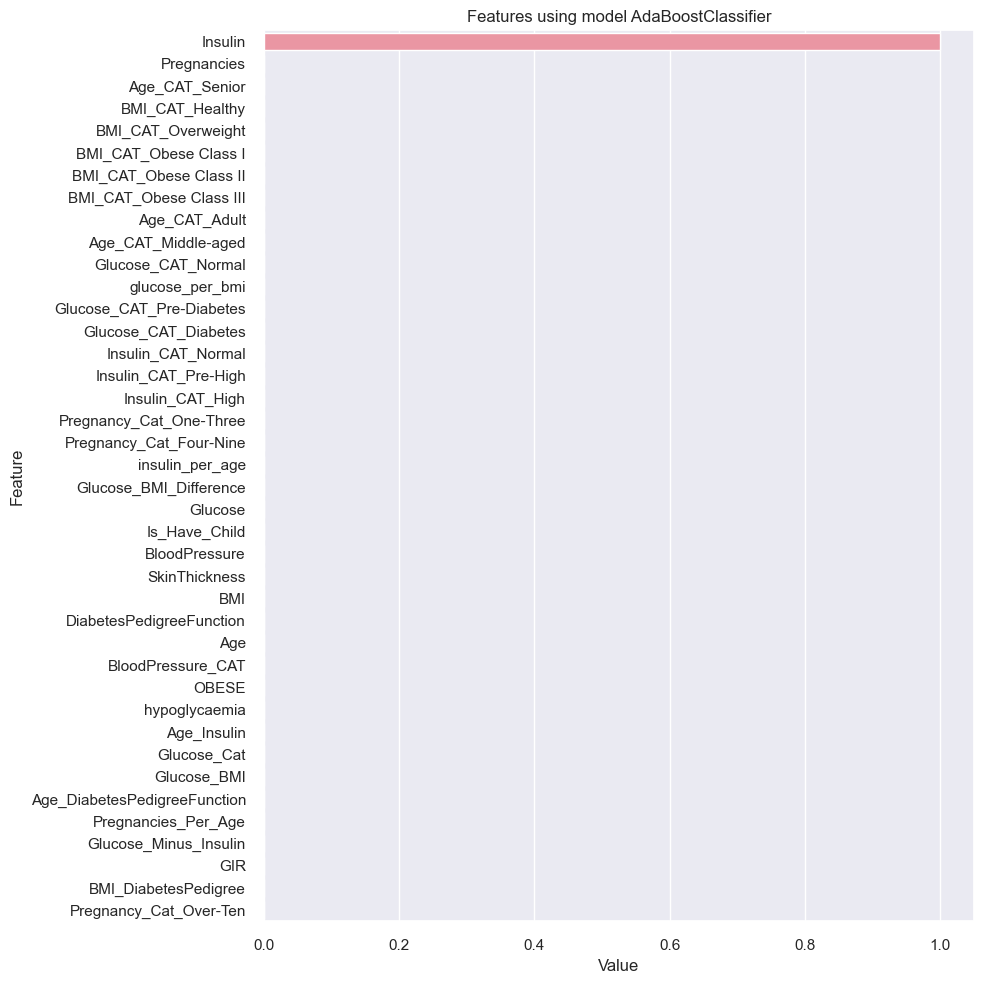

In [902]:
from sklearn.inspection import permutation_importance

def plot_importance(model, X_train, y_train, features, num=None, save=False):
    if type(model).__name__ in ['MLPClassifier', "KNeighborsClassifier"]:
        result = permutation_importance(model, X_train, y_train, n_repeats=10, random_state=0)
        feature_importances = result.importances_mean
    else:
        feature_importances = model.feature_importances_

    feature_imp = pd.DataFrame({'Value': feature_importances, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                    ascending=False)[:num])

    
    # viz = FeatureImportances(model).fit(X_train, y_train)
    plt.title(f'Features using model {type(model).__name__}')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')
    
# Assuming you have X_train and y_train defined
plot_importance(final_model, X_train, y_train, X)


In [903]:
# def disable_catboost_logging():
#     logging.getLogger('catboost').propagate = False


# def enable_catboost_logging():
#     logging.getLogger('catboost').propagate = True


# def hyperparameter_tuning(models, params, X, y, cv=10):
#     best_models = {}

#     for model_name, model in models.items():
#         if model_name not in params:
#             print(
#                 f"Skipping Hyperparameter Tuning for {model_name} as it doesn't require hyperparameters.")
#             continue

#         print(f"Performing Hyperparameter Tuning for {model_name}...")
#         if isinstance(model, CatBoostClassifier):
#             model.set_params(verbose=False)

#         grid_search_cv = GridSearchCV(
#             model, params[model_name], cv=cv, n_jobs=-1)
#         grid_search_cv.fit(X, y)

#         if isinstance(model, CatBoostClassifier):
#             enable_catboost_logging()

#         best_params = grid_search_cv.best_params_
#         best_score = grid_search_cv.best_score_
#         best_model = grid_search_cv.best_estimator_

#         best_models[model_name] = {
#             'Best Parameters': best_params,
#             'Best Score': best_score,
#             'Best Model': best_model
#         }

#         print(f"{model_name} - Best Parameters:", best_params)
#         print(f"{model_name} - Best Score:", best_score)
#         print(f"{model_name} - Best Model:", best_model)
#         print("\n")

#     return best_models


# models = {
#     # 'LogisticRegression': LogisticRegression(),
#     # 'DecisionTree': DecisionTreeClassifier(),
#     # 'RandomForest': RandomForestClassifier(),
#     # 'SVM': SVC(),
#     # 'KNN': KNeighborsClassifier(),
#     # 'GradientBoosting': GradientBoostingClassifier(),
#     # 'LightGBM': LGBMClassifier(),
#     'CatBoost': CatBoostClassifier(),
# }

# params = {
#     # 'LogisticRegression': {'C': np.arange(1,11), 'penalty': ['l1', 'l2'], 'max_iter': np.arange(100, 1501, 100)},
#     # 'DecisionTree': {'max_depth': np.arange(5,51,5), 'min_samples_split': np.arange(4,33,4)},
#     # 'RandomForest': {'n_estimators': np.arange(100,301,100), 'max_depth': np.arange(4,33,4)},
#     # 'SVM': {'C': np.arange(1,11), 'kernel': ['linear', 'rbf']},
#     # 'KNN': {'n_neighbors': np.arange(5,51,5), 'weights': ['uniform', 'distance']},
#     # 'GradientBoosting': {'n_estimators': np.arange(100,301,100), 'learning_rate': np.arange(0,1.01,0.05)},
#     # 'LightGBM': {'num_leaves': np.arange(300,701,100), 'max_depth': np.arange(3, 7)},
#     'CatBoost': {'iterations': [200, 1000], 'depth': np.arange(4, 6),  "learning_rate": [0.01, 0.02]},
# }

# best_models = hyperparameter_tuning(models, params, X_train, y_train)


# def results_to_dataframe(best_models):
#     results = []

#     for model_name, model_info in best_models.items():
#         params = model_info['Best Parameters']
#         score = model_info['Best Score']
#         best_model = model_info['Best Model']

#         results.append({
#             'Model': model_name,
#             'Best Parameters': params,
#             'Best Score': score
#         })

#     return pd.DataFrame(results)


# result_df = results_to_dataframe(best_models)
# print(result_df.sort_values(by='Best Score', ascending=False))

# final = CatBoostClassifier(**result_df.loc[0, "Best Parameters"], random_state=random_state, verbose=False).fit(X_train, y_train)
# print(cross_val_score(final, X, y, cv = 10).mean())

# Saving and Loading Model

In [904]:
joblib.dump(catboost_final, 'diabets_model.pkl')
# cart_model_from_disc = joblib.load('diabets_model.pkl')

['diabets_model.pkl']